In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
%matplotlib inline

In [2]:
import geopandas as gpd

In [3]:
# Notebook Styling 
sns.set()
pd.options.display.max_columns = None
display(HTML("<style>.container { width:100% !important; }</style>"))

# Data Sources

The Chicago crimes data set used in this notebook is publicly available on the [Chicago Data Portal](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2), as are the shapefiles for the current [Chicago police beats](https://data.cityofchicago.org/Public-Safety/Boundaries-Police-Beats-current-/aerh-rz74).


In [4]:
def process_chicrimes(chi_crimes):
    chi_crimes['Date'] = pd.to_datetime(chi_crimes['Date'], format='%m/%d/%Y %I:%M:%S %p')
    chi_crimes['Updated On'] = pd.to_datetime(chi_crimes['Updated On'], format='%m/%d/%Y %I:%M:%S %p')
    chi_crimes.drop(['Location', 'X Coordinate', 'Y Coordinate'], axis=1, inplace=True)
    chi_crimes['Block'] = chi_crimes['Block'].astype('category')
    chi_crimes['IUCR'] = chi_crimes['IUCR'].astype('category')
    chi_crimes['Primary Type'] = chi_crimes['Primary Type'].astype('category')
    chi_crimes['Description'] = chi_crimes['Description'].astype('category')
    chi_crimes['Location Description'] = chi_crimes['Primary Type'].astype('category')
    chi_crimes['Beat'] = chi_crimes['Beat'].astype(int)
    chi_crimes['District'] = chi_crimes['District'].astype('category')
    chi_crimes['Ward'] = chi_crimes['Ward'].astype('category')
    chi_crimes['Community Area'] = chi_crimes['Community Area'].astype('category')
    chi_crimes['FBI Code'] = chi_crimes['FBI Code'].astype('category')
    chi_crimes['Hour'] = chi_crimes['Date'].dt.hour
    chi_crimes['Week'] = chi_crimes['Date'].dt.weekofyear
    chi_crimes['Day'] = chi_crimes['Date'].dt.dayofyear
    chi_crimes['Weekday_name'] = chi_crimes['Date'].dt.day_name()
    chi_crimes['Weekday'] = chi_crimes['Date'].dt.dayofweek
    chi_crimes['Month'] = chi_crimes['Date'].dt.month
    chi_crimes['Hour'] = chi_crimes['Hour'].astype('category')
    chi_crimes['Week'] = chi_crimes['Week'].astype('category')
    chi_crimes['Day'] = chi_crimes['Day'].astype('category')
    chi_crimes['Weekday'] = chi_crimes['Weekday'].astype('category')
    chi_crimes['Month'] = chi_crimes['Month'].astype('category')
    return chi_crimes

In [5]:
CSV_PATH = os.path.join('..', 'data_raw', 'Crimes_-_2001_to_present.csv')
crime_dtypes = {'District':str,
                'Ward':str, 
                'Community Area':str}
chi_crimes = pd.read_csv(CSV_PATH, dtype=crime_dtypes, encoding='latin1') 

/home/matt/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
chi_crimes.head(2)

ID Case Number                    Date               Block  IUCR  \
0  11034701    JA366925  01/01/2001 11:00:00 AM     016XX E 86TH PL  1153   
1  11227287    JB147188  10/08/2017 03:00:00 AM  092XX S RACINE AVE  0281   

          Primary Type                          Description  \
0   DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT OVER $ 300   
1  CRIM SEXUAL ASSAULT                       NON-AGGRAVATED   

  Location Description  Arrest  Domestic  Beat District Ward Community Area  \
0            RESIDENCE   False     False   412      004    8             45   
1            RESIDENCE   False     False  2222      022   21             73   

  FBI Code  X Coordinate  Y Coordinate  Year              Updated On  \
0       11           NaN           NaN  2001  08/05/2017 03:50:08 PM   
1       02           NaN           NaN  2017  02/11/2018 03:57:41 PM   

   Latitude  Longitude Location  
0       NaN        NaN      NaN  
1       NaN        NaN      NaN

In [7]:
chi_crimes = process_chicrimes(chi_crimes)

In [8]:
def freq_selector(freq):
    freq = freq.lower()
    if freq == 'month':
        return 'M'
    elif freq == 'quarter':
        return 'Q'
    else:
        return 'Y'

In [9]:
def arrest_plot(crime_descr, crime_df=chi_crimes, crime_col='Description', start_date='2005-01-01', 
                end_date='today', frequency='Year', arrest=True, figsize=(14,6), more_label='', plot_Laquan=False):
    lable_descr = crime_descr.title()
    
    if isinstance(crime_descr, list):
        df = crime_df.loc[(chi_crimes[crime_col].isin(crime_descr)) & (chi_crimes['Date'] >= start_date) & 
                          (chi_crimes['Date'] <= end_date)]
    else:
        df = crime_df.loc[(chi_crimes[crime_col] == crime_descr) & (chi_crimes['Date'] >= start_date) & 
                          (chi_crimes['Date'] <= end_date)]
    
    fig, ax = plt.subplots(sharex=True, figsize=figsize)
    count_df = df.groupby([pd.Grouper(key='Date', freq=freq_selector(frequency))]).count()['Case Number']
    count_df.plot(ax=ax, kind='line', legend=None, label=f"{lable_descr} Cases", color='#0570b0')
    arr_count_df = df.loc[df['Arrest'] == True].groupby([pd.Grouper(key='Date', freq=freq_selector(frequency))]).count()['Case Number']
    arr_count_df.plot(ax=ax, kind='line', legend=None, label=f"{lable_descr} Cases w/ Arrest", color='#41ae76')
    
    ax.set_ylabel(f"{lable_descr} Cases \n(per {frequency})", fontsize=18)
    ax.set_title(f"{more_label}{lable_descr} Cases per {frequency} from {start_date} to {end_date}", fontsize=18)
    ax.set_xlabel('Date', fontsize=18)
    
    ax.set_ylim([0, 1.1 * max([count_df.max(), arr_count_df.max()])])
    if plot_Laquan:
        if freq_selector(frequency) == 'Y':
            ax.axvline(x='2015-04-15', label='Laquan McDonald becomes major News', linestyle='--', color='#b30000')
#             ax.axvline(x='2015', label='Laquan McDonald Shooting', linestyle='--', color='#ef6548')
        else:
            ax.axvline(x='2014-11-01', label='Laquan McDonald Shooting', linestyle='--', color='#ef6548')
            ax.axvline(x='2015-04-15', label='Laquan McDonald becomes major News', linestyle='--', color='#b30000')
    ax.legend()    

In [11]:
ZIP_SHP_PATH = os.path.join('zip://', '..', 'shapefiles', 'Boundaries - Police Beats (current).zip')
beats = gpd.read_file(ZIP_SHP_PATH)
beats['beat_num'] = beats['beat_num'].astype('int64')

In [12]:
def map_counts(crime_descr, crime_col='Primary Type', df_=chi_crimes, start_date='2001-01-01', more_label='',
               end_date='2019-01-03', gdf=beats, figsize=(10,10), my_cmap='YlGn', scale=0.6, tight=True, title_fs=None):
    df = df_[(df_['Date'] >= start_date) & (df_['Date'] <= end_date) & (df_[crime_col] == crime_descr.upper())]
    count_df = df.groupby(['Beat', crime_col]).count()['Case Number'].unstack(fill_value=0).stack().reset_index()
    count_df.rename({0:'Count'}, axis=1, inplace=True)
    
    map_df = pd.merge(left=gdf, right=count_df.loc[count_df[crime_col] == crime_descr.upper()], right_on='Beat', left_on='beat_num', how='left')
    map_df['Count'] = map_df['Count'].fillna(0)
    vmin = map_df['Count'].min()
    vmax = map_df['Count'].max()
    fig, ax = plt.subplots(figsize=figsize)
    base = gdf.plot(figsize=figsize, color='white', edgecolor='black', linewidth=2, ax=ax)
    map_df.plot(column='Count', ax=base, edgecolor='grey', linewidth=0.4, cmap=my_cmap)
    _ = ax.axis('off')
    title = f"{more_label}{crime_descr} cases per police beat\nfrom {start_date} to {end_date}"
    if len(title) >= 60:
        title = f"{more_label}{crime_descr} cases\nper police beat from {start_date} to {end_date}"
        if not title_fs:
            title_fs = 22
    if not title_fs:
        title_fs = 25
    _ = ax.set_title(title, fontdict={'fontsize': title_fs, 'fontweight':'3'})
    
    sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, shrink=scale)
    if tight:
        plt.tight_layout()

In [13]:
def plot_crime_freq_heatmap(crime_descr, crime_col='Primary Type', x_ax='Weekday', y_ax='Hour',  more_label='',
                            start_date='2001-01-01', end_date='today', df=chi_crimes, cmap='YlGn', figsize=None):
    tmp_df = chi_crimes.loc[(chi_crimes['Date'] >= start_date) & (chi_crimes['Date'] <= end_date) & (chi_crimes[crime_col] == crime_descr)]
    tmp_counts = tmp_df.groupby([tmp_df[y_ax], tmp_df[x_ax]])['ID'].count()
    tmp_counts = tmp_counts.unstack(level=1, fill_value=0)
    
    weekday_names = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
    month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    if x_ax == 'Weekday':
        tmp_counts.columns = tmp_counts.columns.rename_categories(weekday_names)
    if x_ax == 'Month':
        tmp_counts.columns = tmp_counts.columns.rename_categories(month_names)
    if y_ax == 'Weekday':
        if not figsize:
            figsize=(14,4)
        tmp_counts.index = tmp_counts.index.rename_categories(weekday_names)
        y_top = 7
        y_bot = 0
    if y_ax == 'Month':
        if not figsize:
            figsize=(14,6)
        tmp_counts.index = tmp_counts.index.rename_categories(month_names)
        y_top = 12
        y_bot = 1
    if y_ax == 'Hour':
        if not figsize:
            figsize=(14,7)
        y_top = max(list(tmp_counts.index))+1
        y_bot = min(list(tmp_counts.index))
    
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(tmp_counts, ax=ax, annot=False, fmt='d', cmap=cmap)
    ax.tick_params(axis='y', rotation=0)
    ax.set_ylim([y_top, y_bot])
    ax.set_xlabel(x_ax, fontsize=14)
    ax.set_ylabel(y_ax, fontsize=14)
    title = f"Frequency of crime: '{more_label}{crime_descr}' by {y_ax} and {x_ax} from {start_date} to {end_date}"
    if len(title) > 70:
        title = f"Frequency of crime: '{more_label}{crime_descr}' by\n{y_ax} and {x_ax} from {start_date} to {end_date}"
    ax.set_title(title, fontsize=16)
    plt.tight_layout()

# Notebook Default Dates

In [17]:
nb_start_date='2015-01-01'
nb_end_date='2020-06-01'

In [18]:
def produce_visualizations(crime_descr, crime_col='Description', start_date=nb_start_date, end_date=nb_end_date, 
                           more_label='', qmin=0, qmax=1000000):
    if crime_col == 'Primary Type':
        print(f"Number of {crime_descr} Cases by description since 2001")
        query = chi_crimes.loc[(chi_crimes['Primary Type'] == crime_descr), 'Description'].value_counts()
        display(query[(query > qmin) & (query < qmax)])
    arrest_plot(crime_descr=crime_descr, crime_col=crime_col, frequency='year', end_date=end_date, more_label=more_label)
    arrest_plot(crime_descr=crime_descr, crime_col=crime_col, frequency='month', end_date=end_date, more_label=more_label)
    plot_crime_freq_heatmap(crime_descr=crime_descr, crime_col=crime_col, x_ax='Hour', y_ax='Weekday', 
                            start_date=start_date, end_date=end_date, more_label=more_label.upper())
    plot_crime_freq_heatmap(crime_descr=crime_descr, crime_col=crime_col, x_ax='Hour', y_ax='Month', 
                            start_date=start_date, end_date=end_date, more_label=more_label.upper())
    plot_crime_freq_heatmap(crime_descr=crime_descr, crime_col=crime_col, x_ax='Month', y_ax='Weekday', 
                            start_date=start_date, end_date=end_date, figsize=(10,5), more_label=more_label.upper())
    map_counts(crime_descr=crime_descr, crime_col=crime_col, start_date=start_date, end_date=end_date, 
               scale=0.65, more_label=more_label.upper())

## Primary types of crimes in the public Chicago Crimes data set

In [19]:
chi_crimes['Primary Type'].value_counts()

THEFT                                1506564
BATTERY                              1303584
CRIMINAL DAMAGE                       810399
NARCOTICS                             731065
ASSAULT                               448234
OTHER OFFENSE                         442801
BURGLARY                              402045
MOTOR VEHICLE THEFT                   327731
DECEPTIVE PRACTICE                    291737
ROBBERY                               267608
CRIMINAL TRESPASS                     202979
WEAPONS VIOLATION                      80161
PROSTITUTION                           69186
PUBLIC PEACE VIOLATION                 49843
OFFENSE INVOLVING CHILDREN             49088
CRIM SEXUAL ASSAULT                    28654
SEX OFFENSE                            27089
INTERFERENCE WITH PUBLIC OFFICER       17200
GAMBLING                               14576
LIQUOR LAW VIOLATION                   14365
ARSON                                  11716
HOMICIDE                               10250
KIDNAPPING

## Crime frequency by time of day, day of week, day of month, and police beat 

## HOMICIDE

Number of HOMICIDE Cases by description since 2001


FIRST DEGREE MURDER         10197
RECKLESS HOMICIDE              49
INVOLUNTARY MANSLAUGHTER        4
Name: Description, dtype: int64

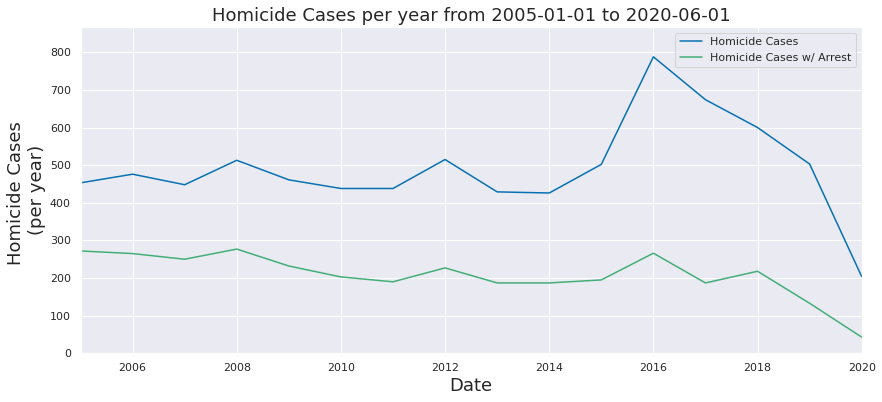

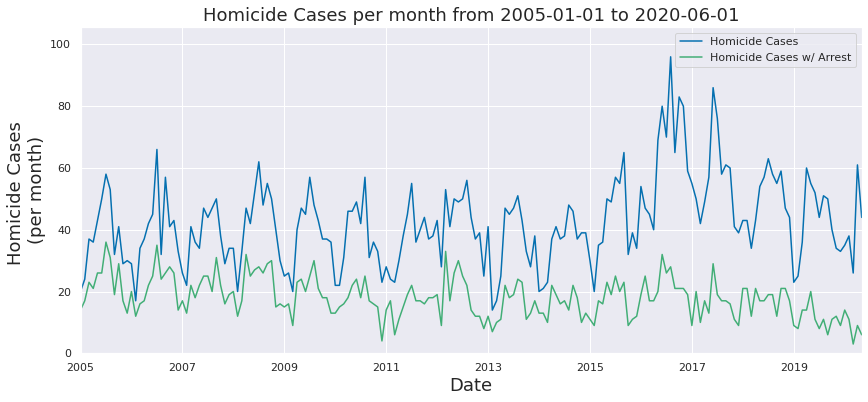

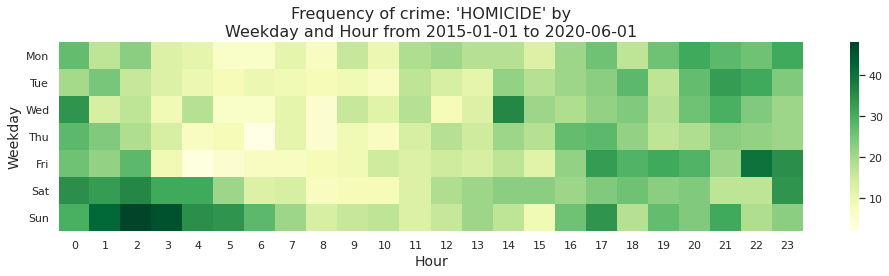

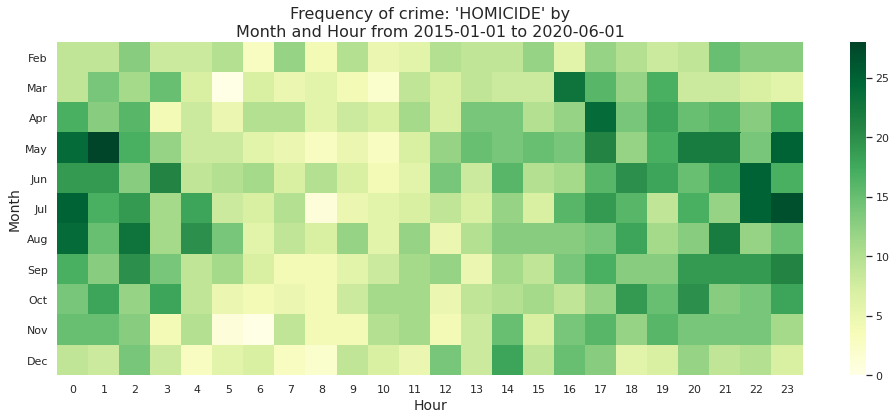

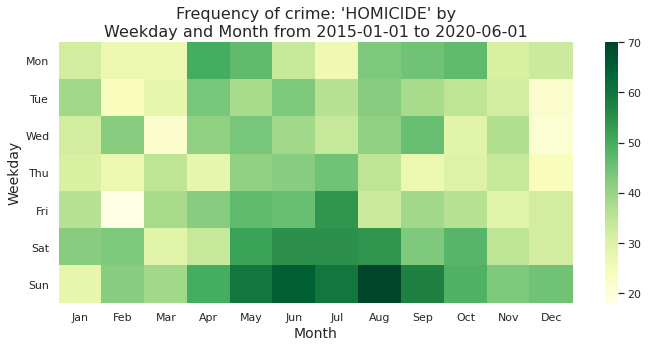

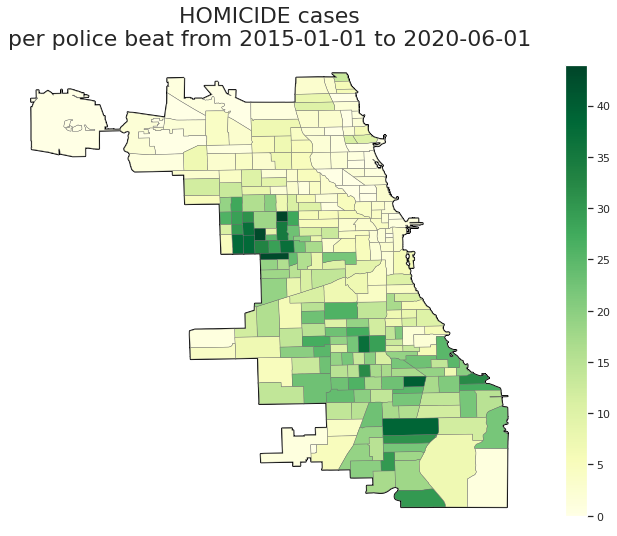

In [20]:
produce_visualizations(crime_descr='HOMICIDE', crime_col='Primary Type', start_date=nb_start_date, end_date=nb_end_date, 
                       more_label='', qmin=0)

## BATTERY: All

Number of BATTERY Cases by description since 2001


DOMESTIC BATTERY SIMPLE                                        551946
SIMPLE                                                         525898
AGGRAVATED: OTHER DANG WEAPON                                   70146
AGGRAVATED: HANDGUN                                             37647
AGGRAVATED:KNIFE/CUTTING INSTR                                  27938
AGGRAVATED DOMESTIC BATTERY: OTHER DANG WEAPON                  19716
PRO EMP HANDS NO/MIN INJURY                                     16047
AGG PO HANDS NO/MIN INJURY                                      13992
AGGRAVATED DOMESTIC BATTERY: KNIFE/CUTTING INST                 13521
AGG: HANDS/FIST/FEET NO/MINOR INJURY                             5154
AGGRAVATED DOMESTIC BATTERY: HANDS/FIST/FEET SERIOUS INJURY      4549
AGGRAVATED OF A SENIOR CITIZEN                                   2610
AGG: HANDS/FIST/FEET SERIOUS INJURY                              2486
AGGRAVATED PO: OTHER DANG WEAP                                   1628
AGGRAVATED DOMESTIC 

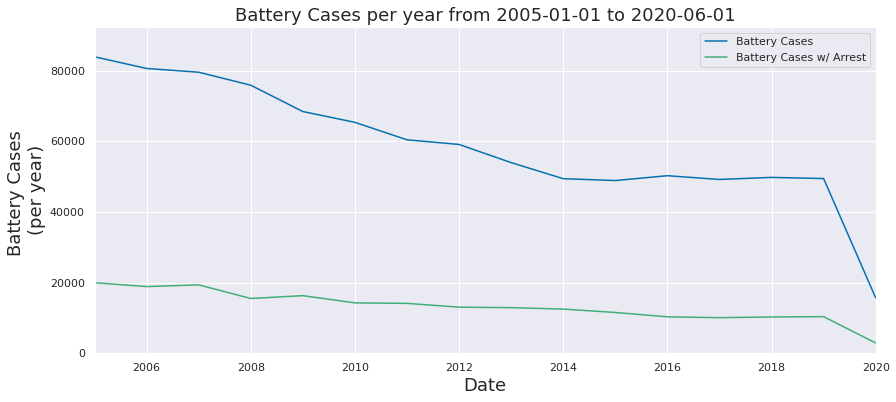

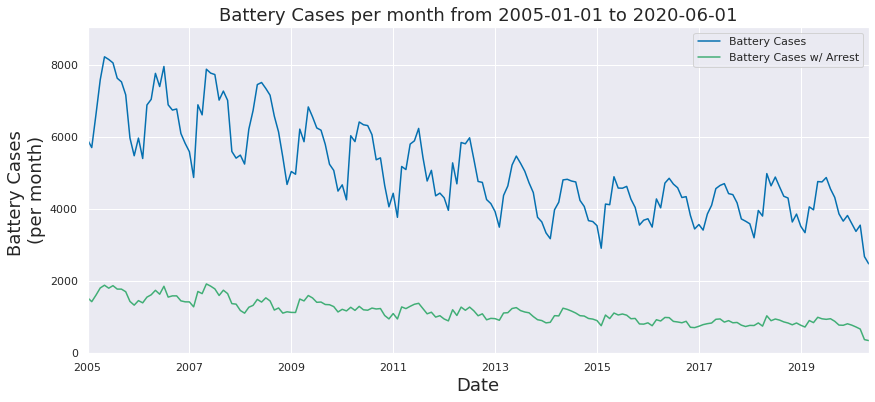

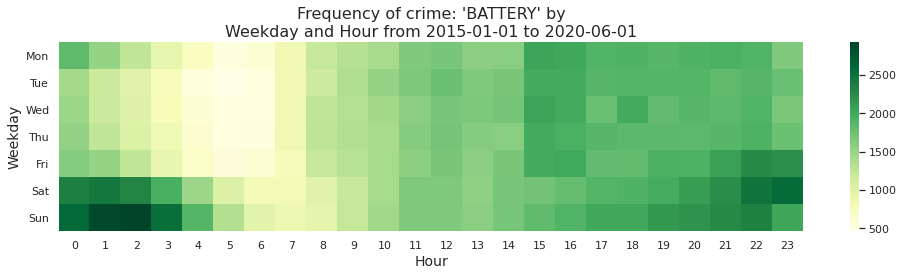

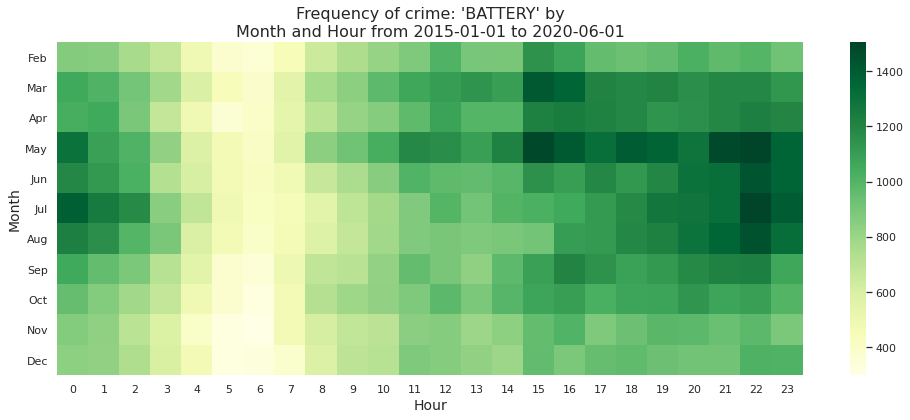

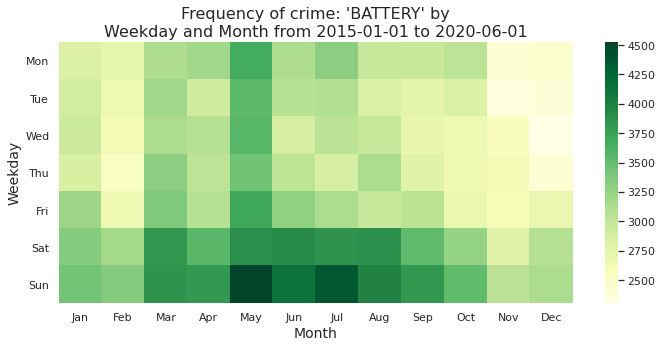

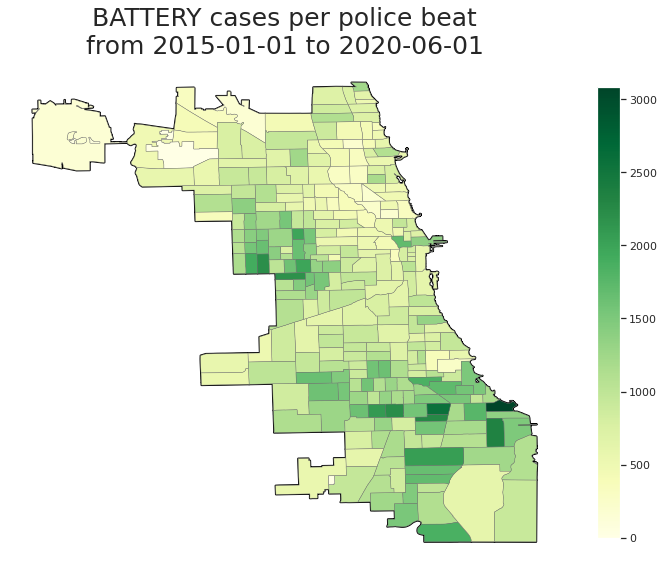

In [21]:
produce_visualizations(crime_descr='BATTERY', crime_col='Primary Type', start_date=nb_start_date, 
                       end_date=nb_end_date, more_label='', qmin=500)

## BATTERY: Domestic Battery without weapons or serious physical injury

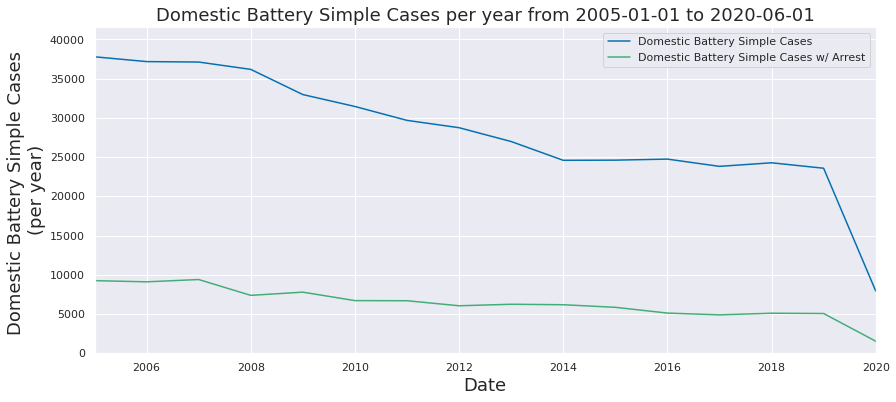

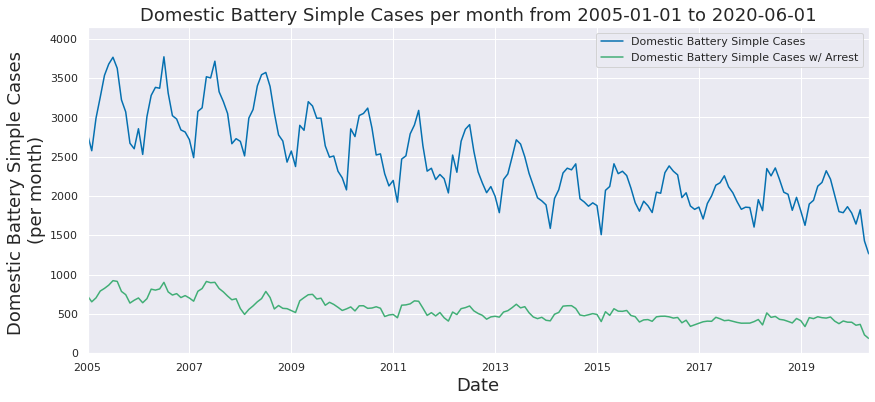

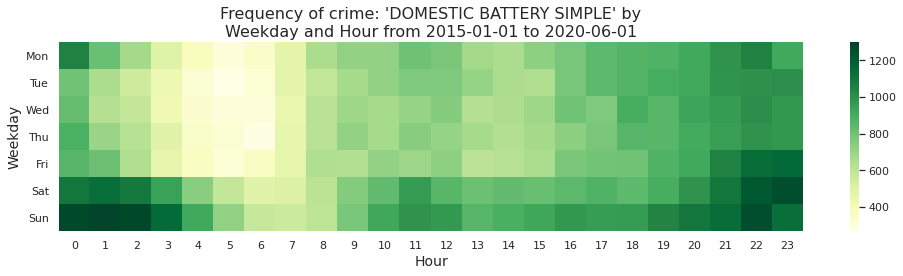

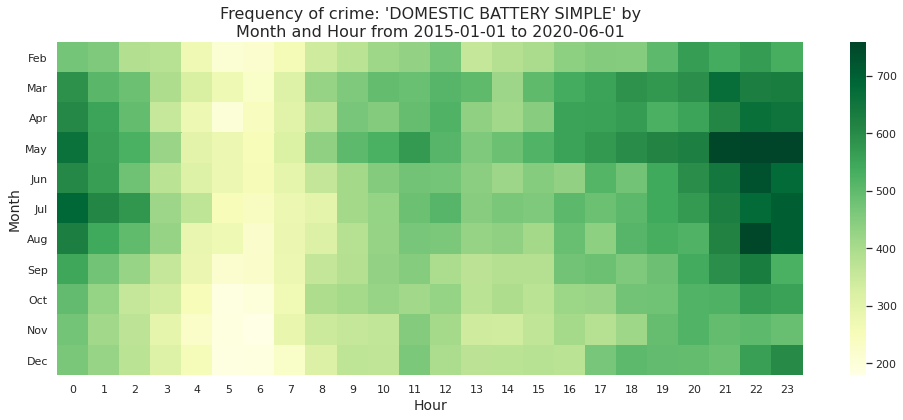

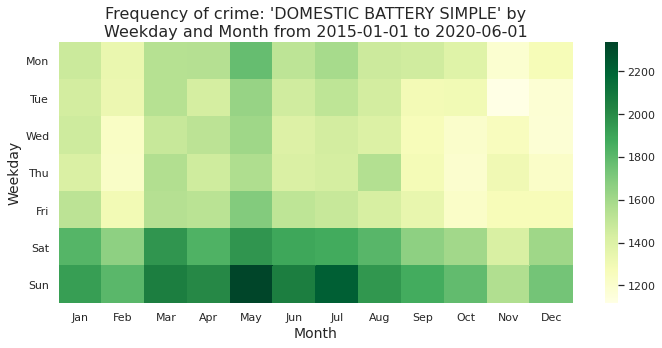

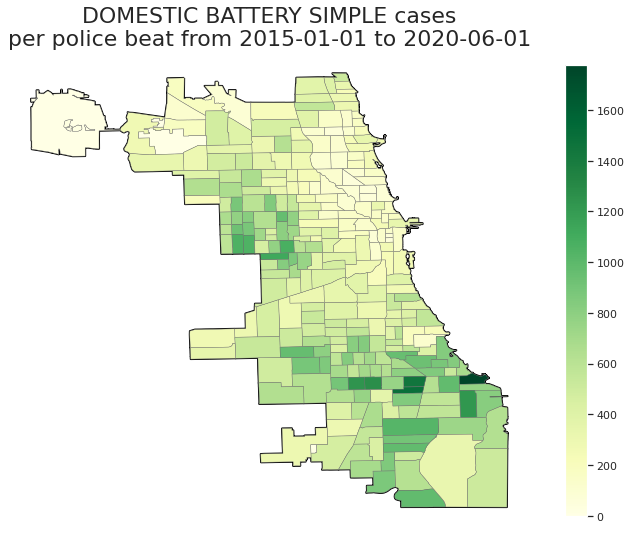

In [22]:
produce_visualizations(crime_descr='DOMESTIC BATTERY SIMPLE', crime_col='Description', start_date=nb_start_date, 
                       end_date=nb_end_date, more_label='')

## BATTERY: Aggravated Battery with a handgun

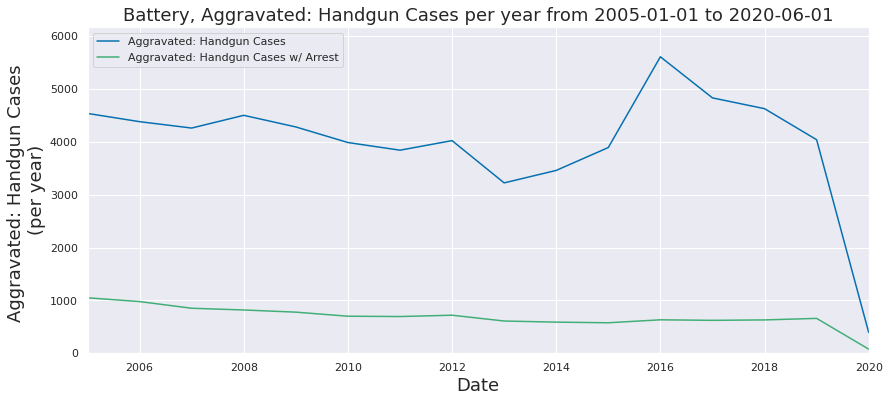

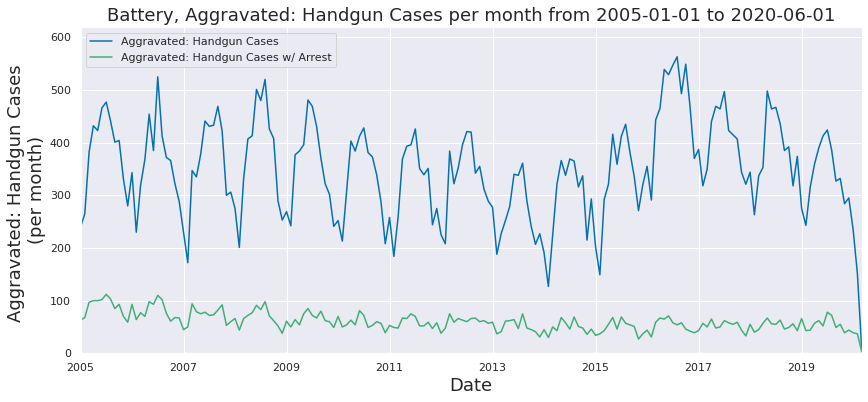

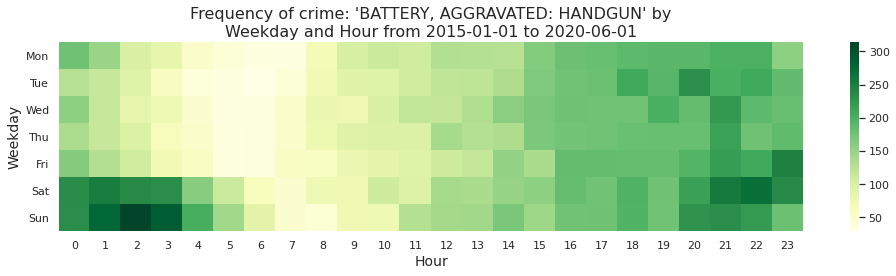

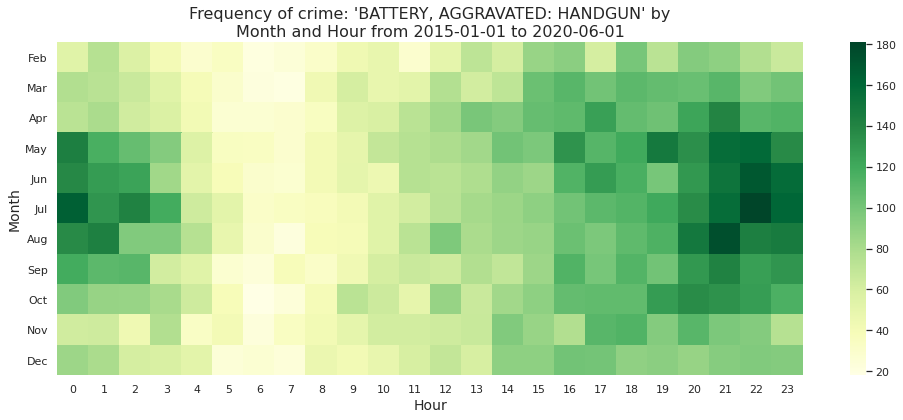

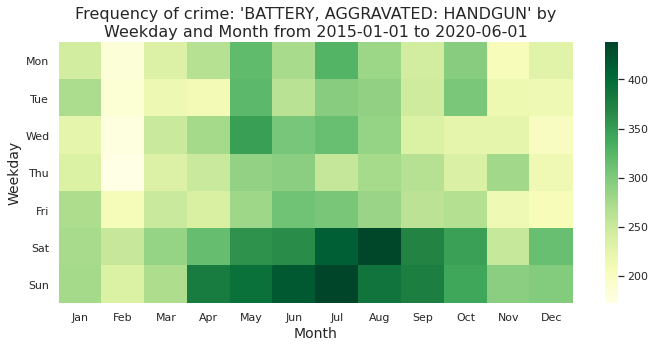

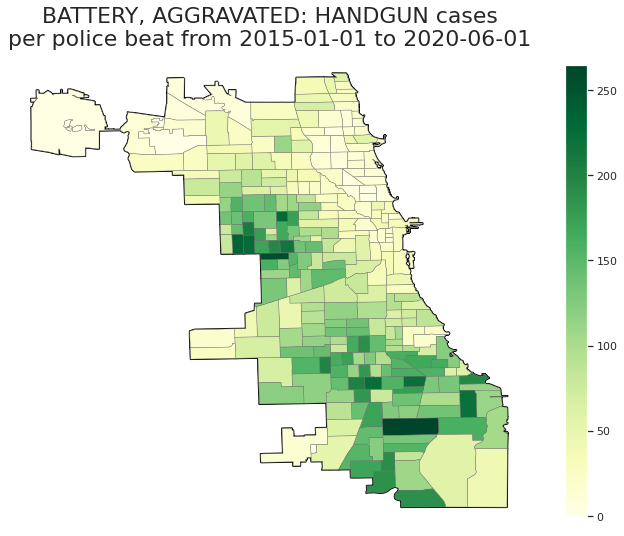

In [23]:
produce_visualizations(crime_descr='AGGRAVATED: HANDGUN', crime_col='Description', start_date=nb_start_date,
                       end_date=nb_end_date, more_label='Battery, ')

## BATTERY: Aggravated Battery with an other dangerous weapon

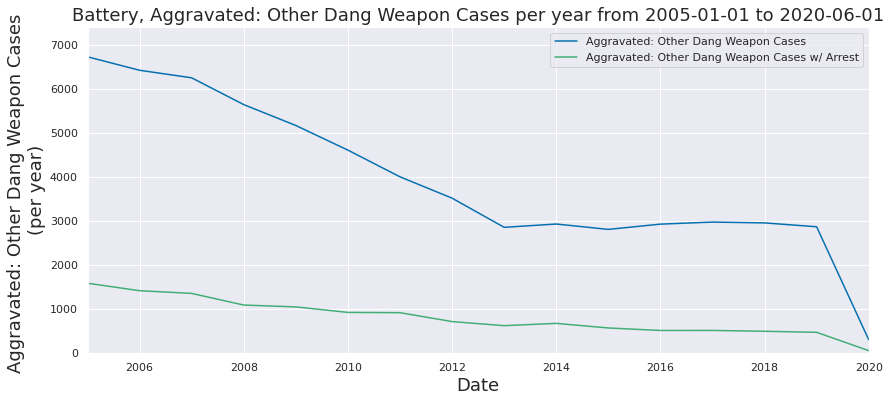

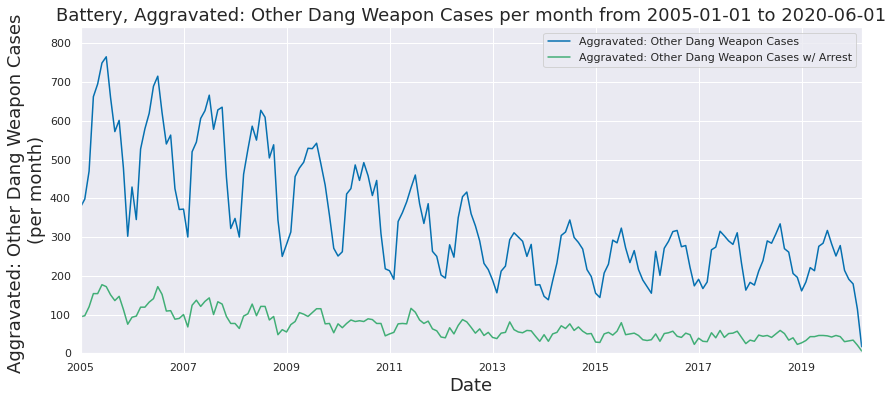

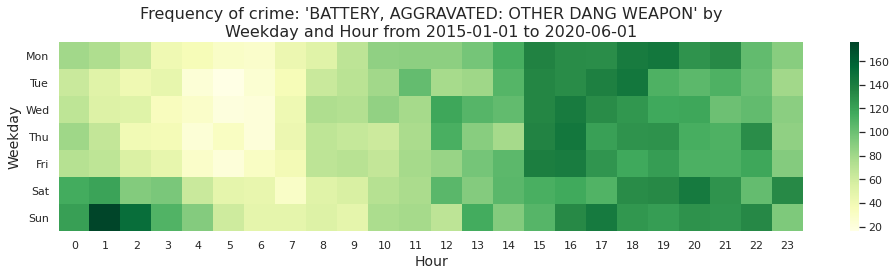

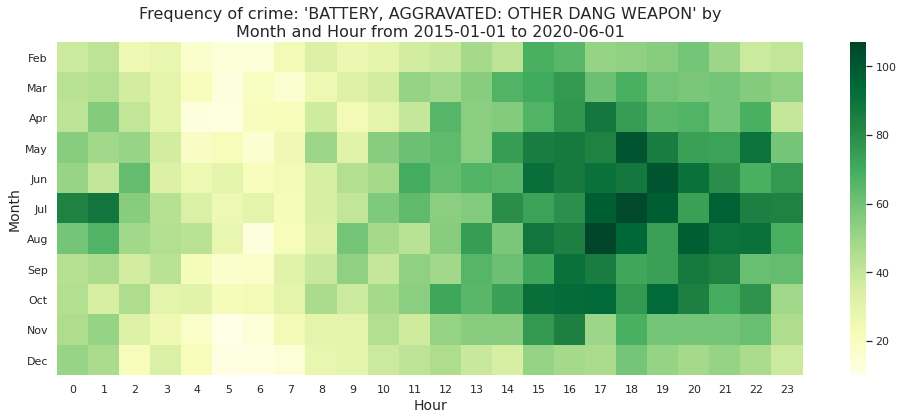

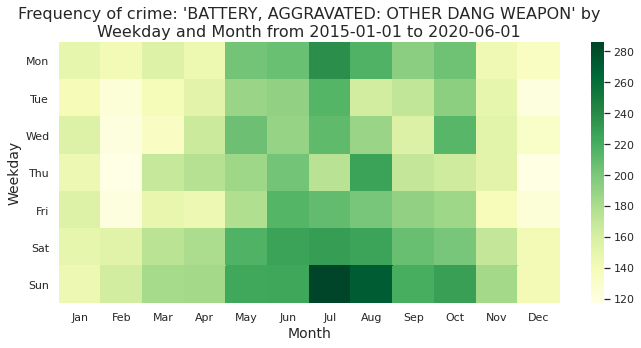

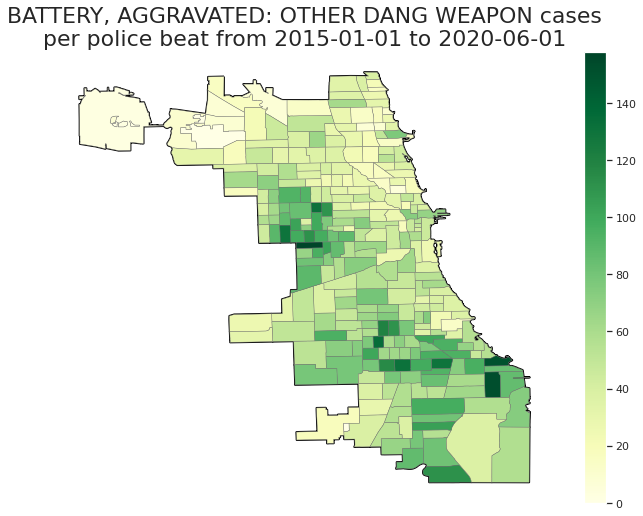

In [24]:
produce_visualizations(crime_descr='AGGRAVATED: OTHER DANG WEAPON', crime_col='Description', start_date=nb_start_date,
                       end_date=nb_end_date, more_label='Battery, ')

## CRIMINAL SEXUAL ASSAULT: All

Number of CRIM SEXUAL ASSAULT Cases by description since 2001


NON-AGGRAVATED                   16171
AGGRAVATED: OTHER                 4608
PREDATORY                         2807
AGGRAVATED: HANDGUN               1719
ATTEMPT NON-AGGRAVATED            1319
AGGRAVATED: KNIFE/CUT INSTR       1056
AGGRAVATED: OTHER DANG WEAPON      304
ATTEMPT AGG: OTHER                 256
ATTEMPT AGG: KNIFE/CUT INSTR       177
ATTEMPT AGG: HANDGUN               152
Name: Description, dtype: int64

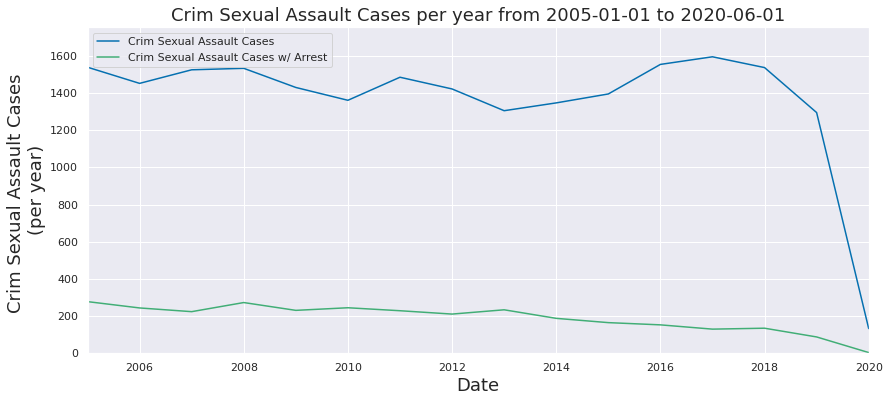

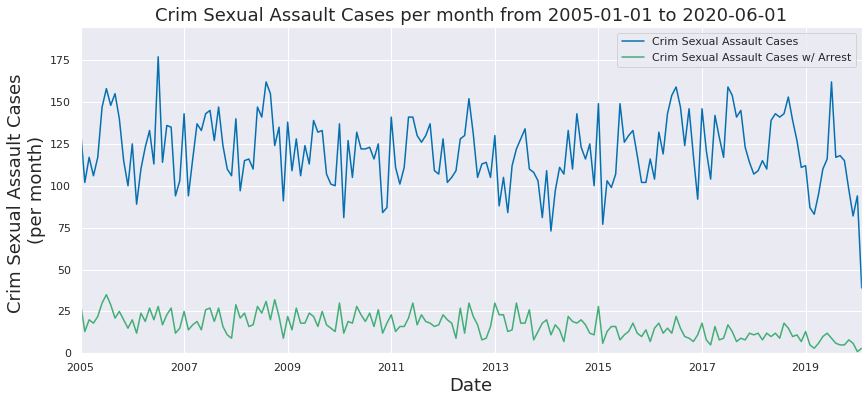

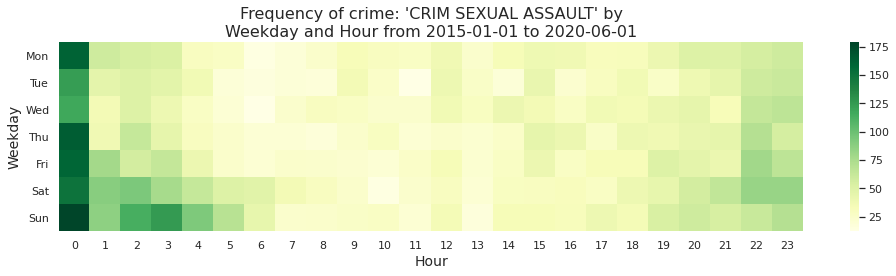

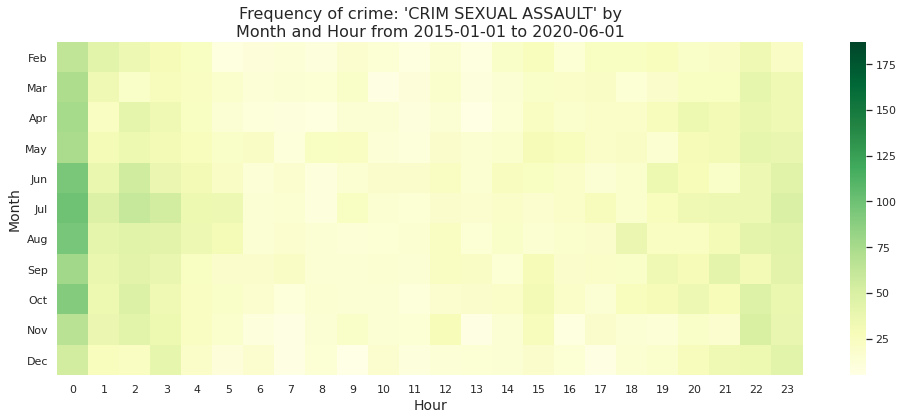

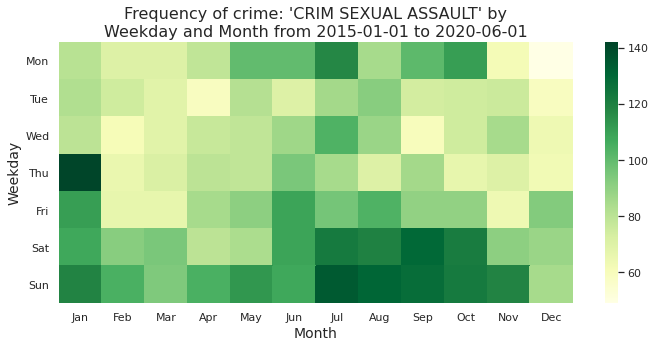

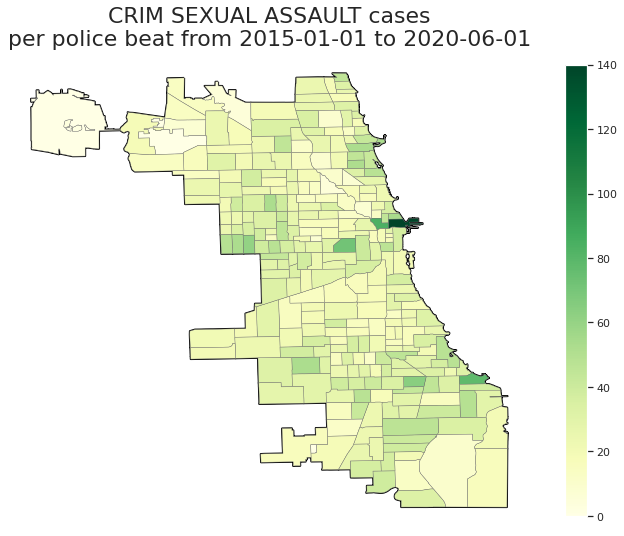

In [25]:
produce_visualizations(crime_descr='CRIM SEXUAL ASSAULT', crime_col='Primary Type', start_date=nb_start_date, 
                       end_date=nb_end_date, qmin=100)

## CRIMINAL SEXUAL ASSAULT: Aggravated

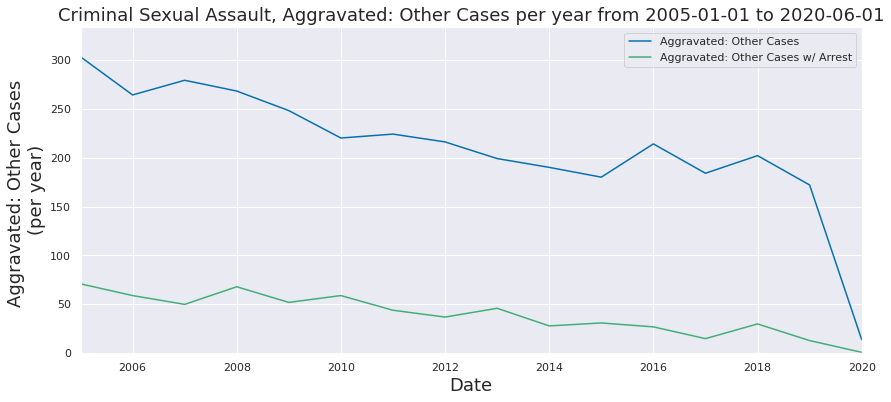

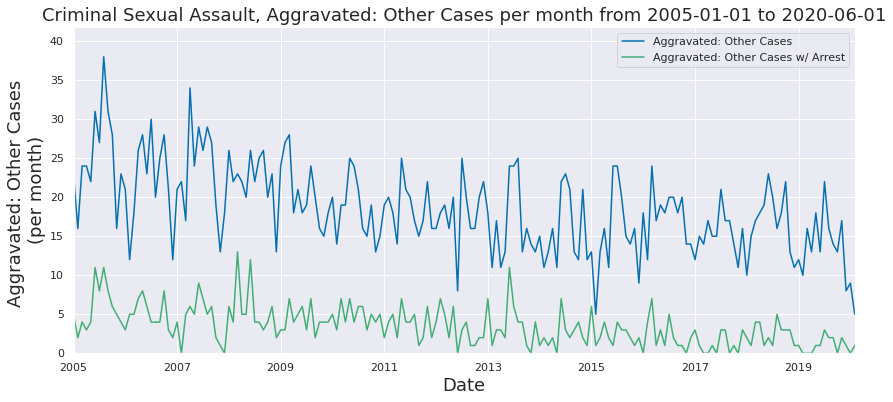

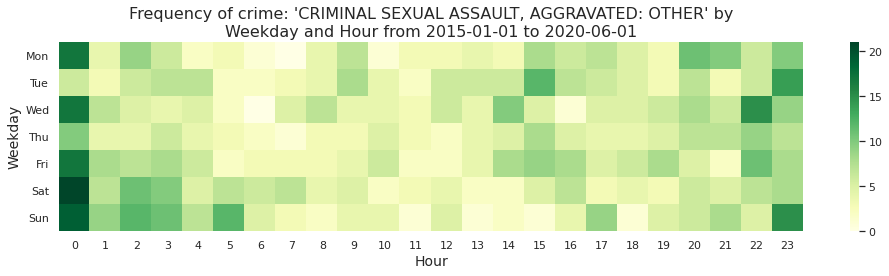

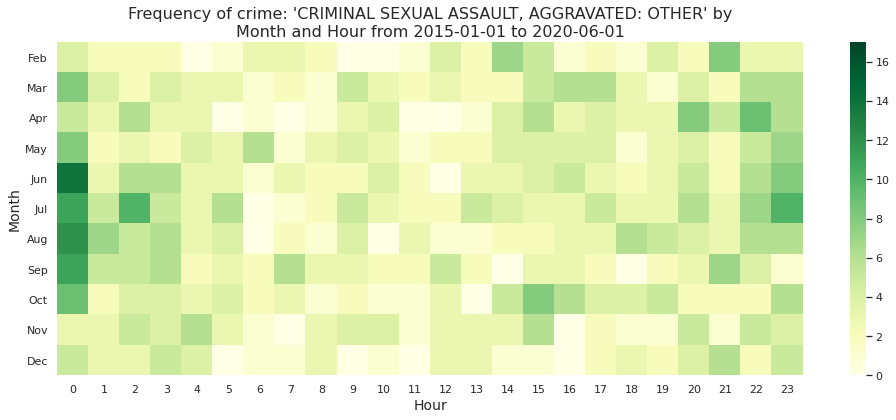

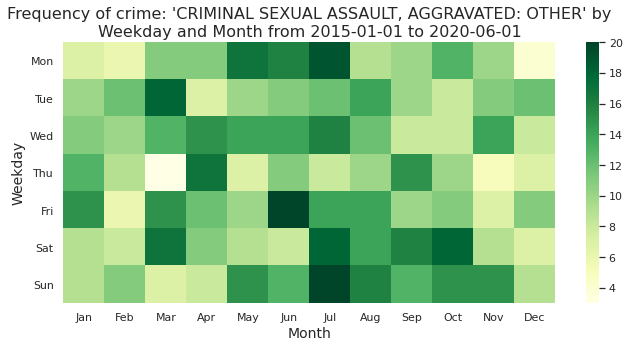

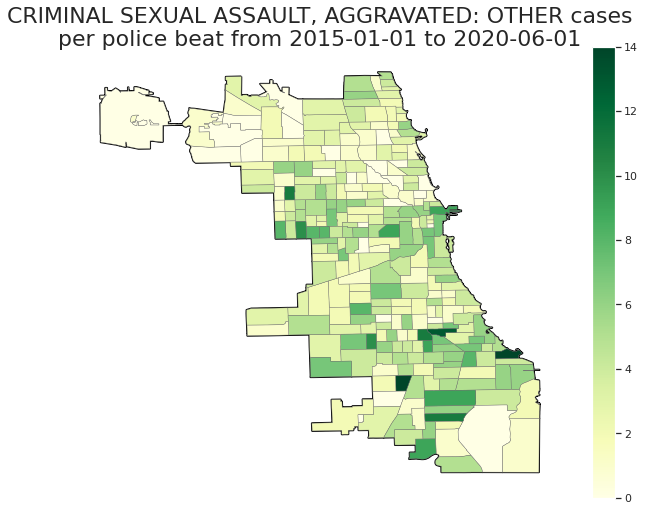

In [26]:
produce_visualizations(crime_descr='AGGRAVATED: OTHER', crime_col='Description', start_date=nb_start_date, 
                       end_date=nb_end_date, more_label='Criminal Sexual Assault, ')

## CRIMINAL SEXUAL ASSAULT: Predatory (Victim age <= 13, offender age >= 17)

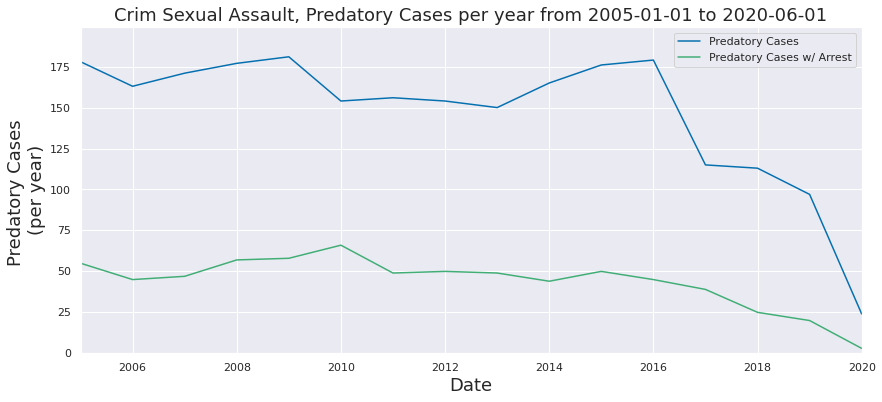

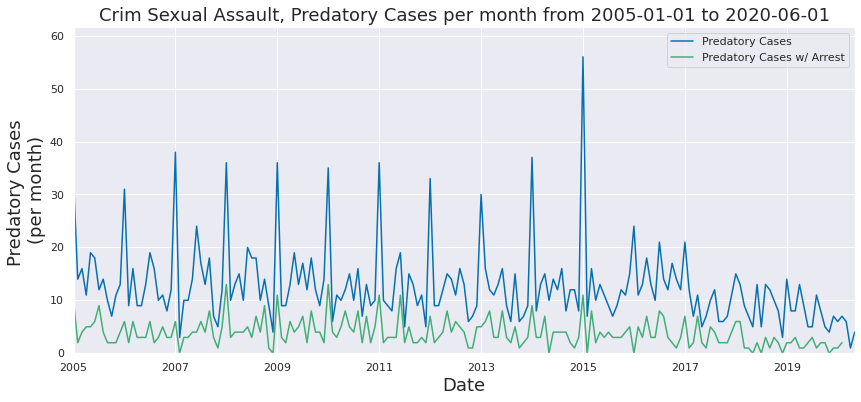

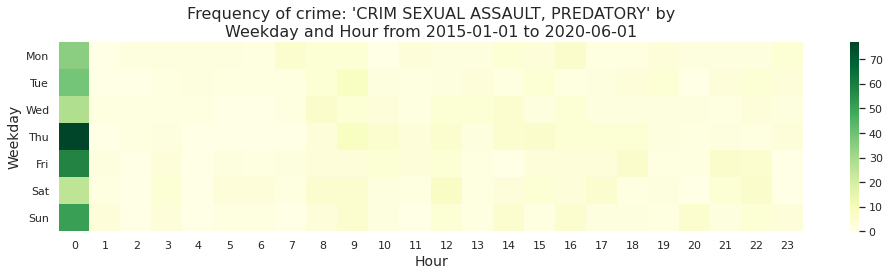

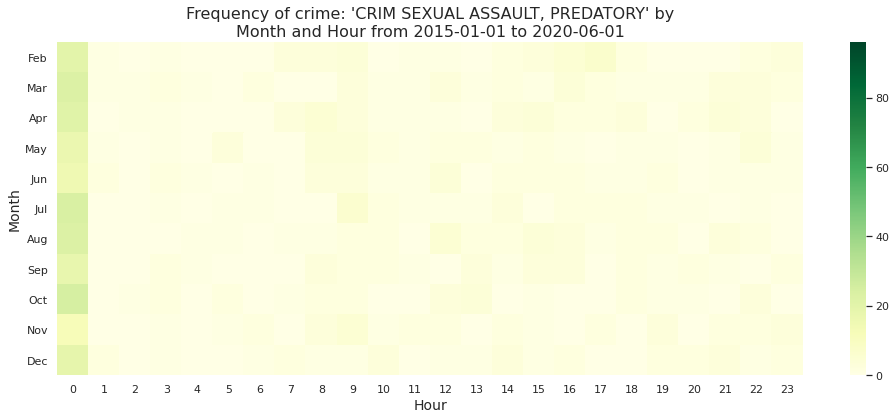

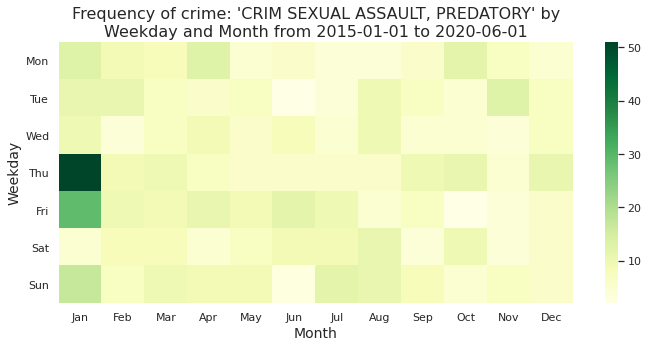

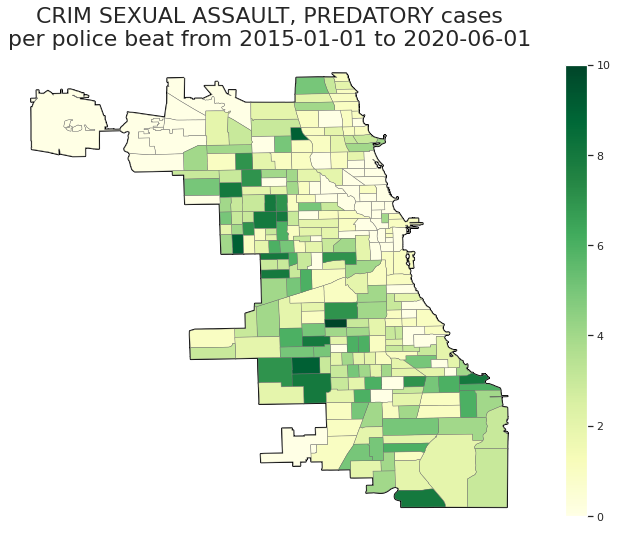

In [27]:
produce_visualizations(crime_descr='PREDATORY', crime_col='Description', start_date=nb_start_date, end_date=nb_end_date, 
                       more_label='Crim Sexual Assault, ')

## OFFENSE INVOLVING CHILDREN: All

Number of OFFENSE INVOLVING CHILDREN Cases by description since 2001


CHILD ABUSE                                            14726
OTHER OFFENSE                                           9494
ENDANGERING LIFE/HEALTH CHILD                           7102
CHILD ABDUCTION                                         3728
AGG CRIM SEX ABUSE FAM MEMBER                           3521
AGG SEX ASSLT OF CHILD FAM MBR                          3001
CRIM SEX ABUSE BY FAM MEMBER                            2173
SEX ASSLT OF CHILD BY FAM MBR                           1507
CHILD PORNOGRAPHY                                       1217
CHILD ABANDONMENT                                        885
CONTRIBUTE DELINQUENCY OF A CHILD                        598
HARBOR RUNAWAY                                           263
AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER        257
AGGRAVATED SEXUAL ASSAULT OF CHILD BY FAMILY MEMBER      164
CONTRIBUTE CRIM DELINQUENCY JUVENILE                     131
Name: Description, dtype: int64

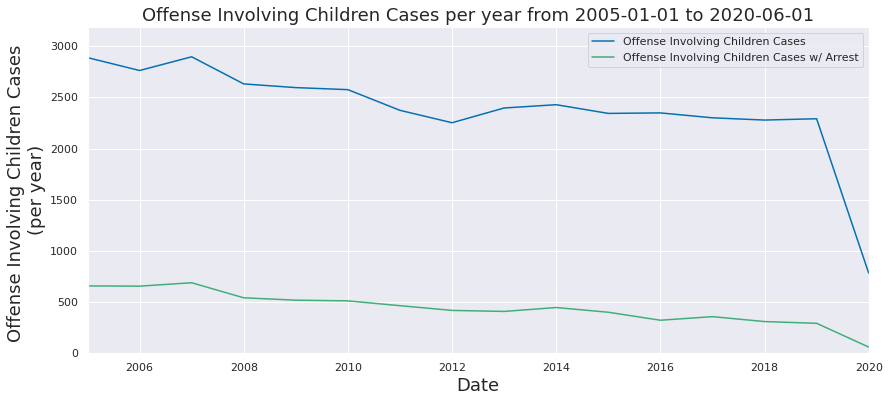

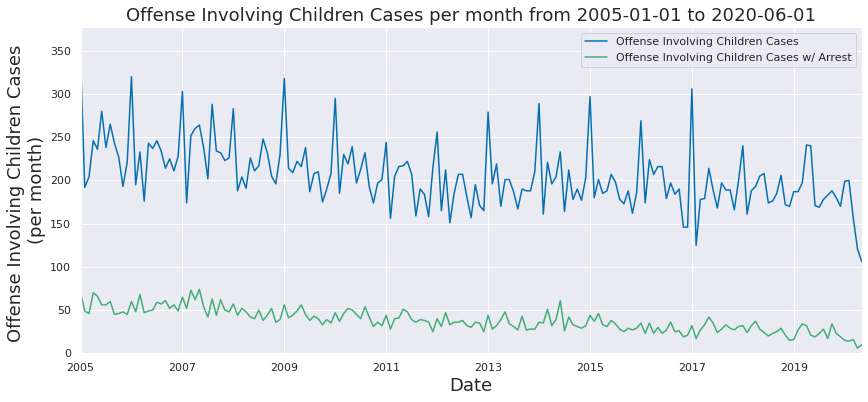

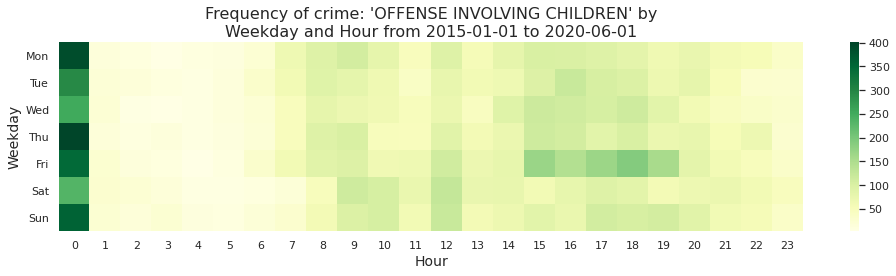

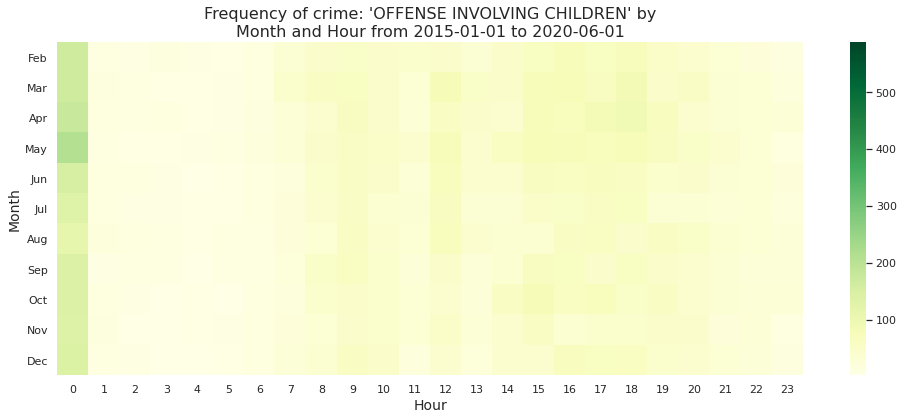

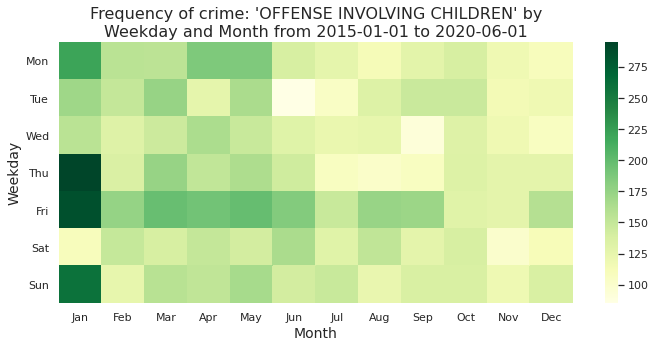

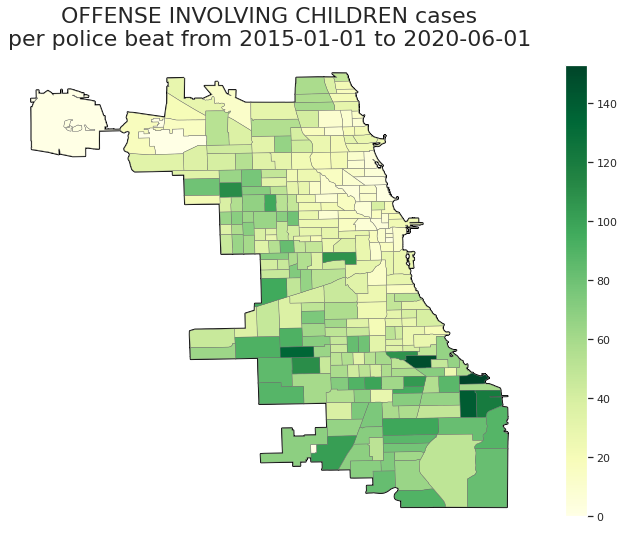

In [28]:
produce_visualizations(crime_descr='OFFENSE INVOLVING CHILDREN', crime_col='Primary Type', start_date=nb_start_date, 
                       end_date=nb_end_date, qmin=100)

## OFFENSE INVOLVING CHILDREN: Aggravated criminal sexual abuse by a family member

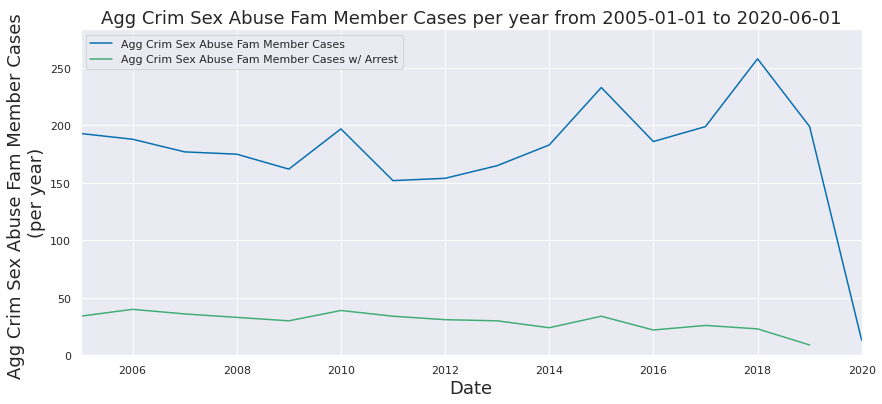

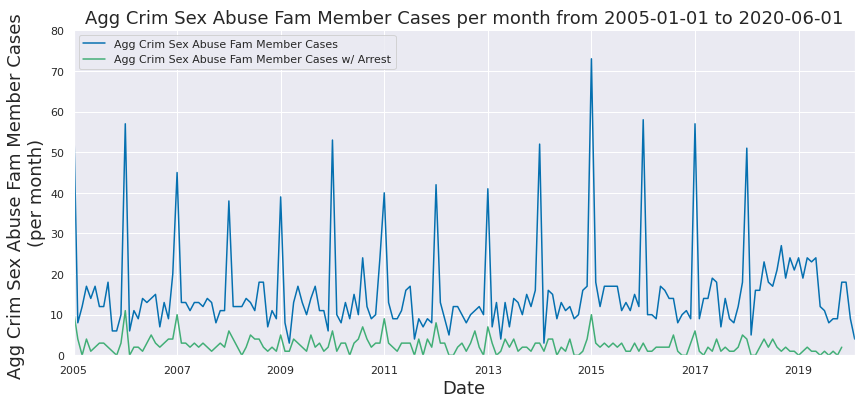

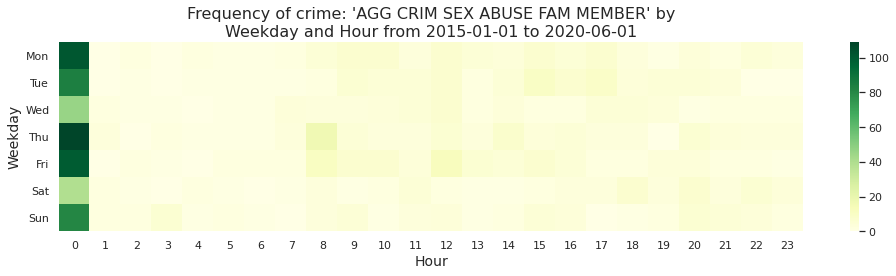

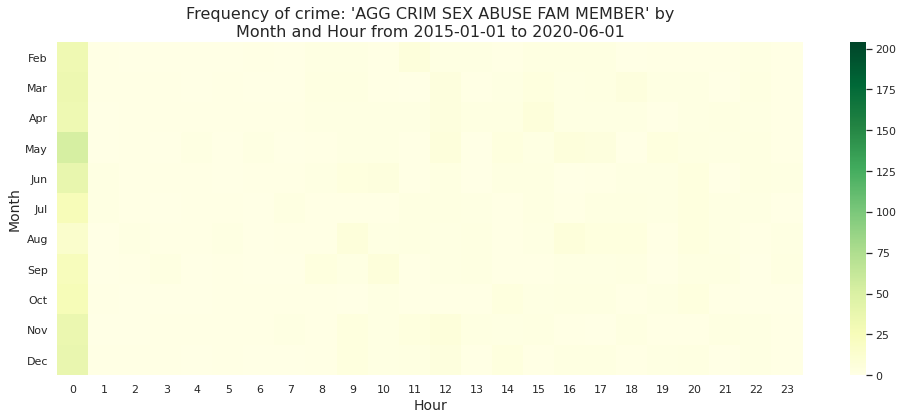

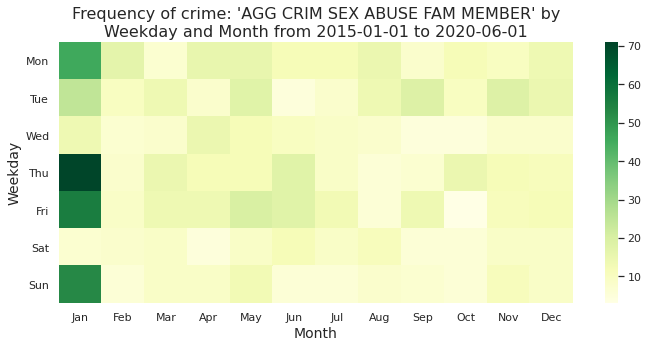

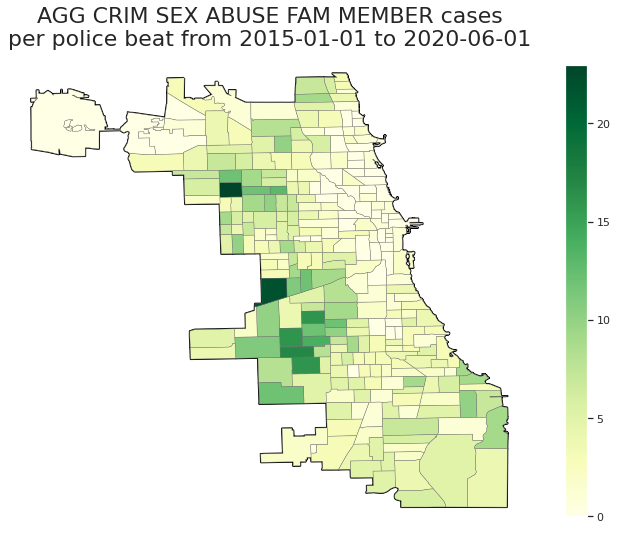

In [29]:
produce_visualizations(crime_descr='AGG CRIM SEX ABUSE FAM MEMBER', crime_col='Description', start_date=nb_start_date, 
                       end_date=nb_end_date)

## WEAPONS VIOLATIONS: All

Number of WEAPONS VIOLATION Cases by description since 2001


UNLAWFUL POSS OF HANDGUN                         52246
UNLAWFUL USE OTHER DANG WEAPON                    8614
UNLAWFUL USE HANDGUN                              4244
RECKLESS FIREARM DISCHARGE                        3686
UNLAWFUL POSS OTHER FIREARM                       2846
UNLAWFUL USE/SALE AIR RIFLE                       2460
POSS FIREARM/AMMO:NO FOID CARD                    2117
UNLAWFUL POSS AMMUNITION                          1601
UNLAWFUL POSSESSION - HANDGUN                      800
UNLAWFUL USE OTHER FIREARM                         726
UNLAWFUL SALE HANDGUN                              228
UNLAWFUL USE - HANDGUN                             170
UNLAWFUL SALE/DELIVERY OF FIREARM AT SCHOOL        153
UNLAWFUL SALE OTHER FIREARM                         89
UNLAWFUL USE - OTHER FIREARM                        74
DEFACE IDENT MARKS OF FIREARM                       40
POSSESS FIREARM / AMMUNITION - NO FOID CARD         15
UNLAWFUL POSSESSION - OTHER FIREARM                 14
UNLAWFUL P

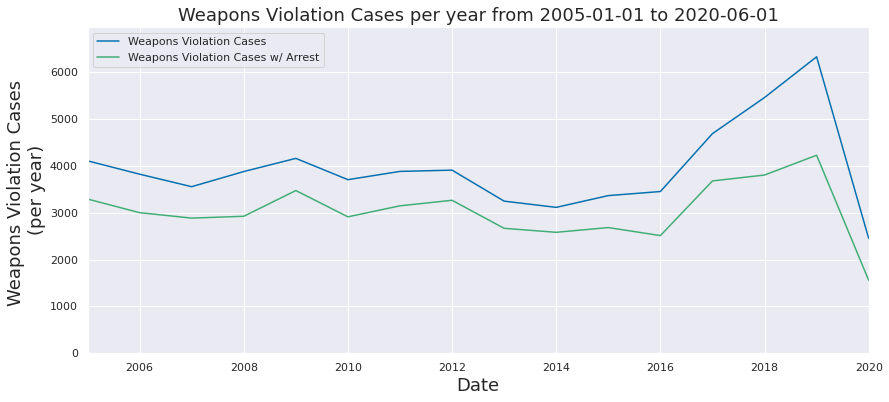

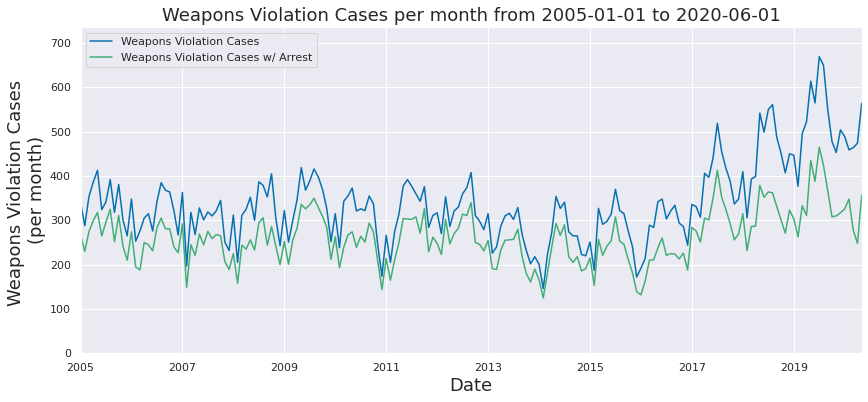

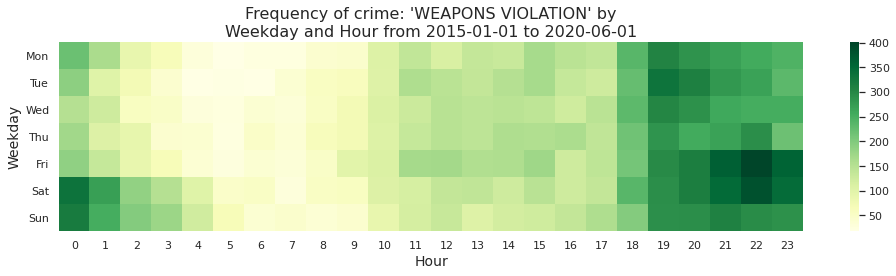

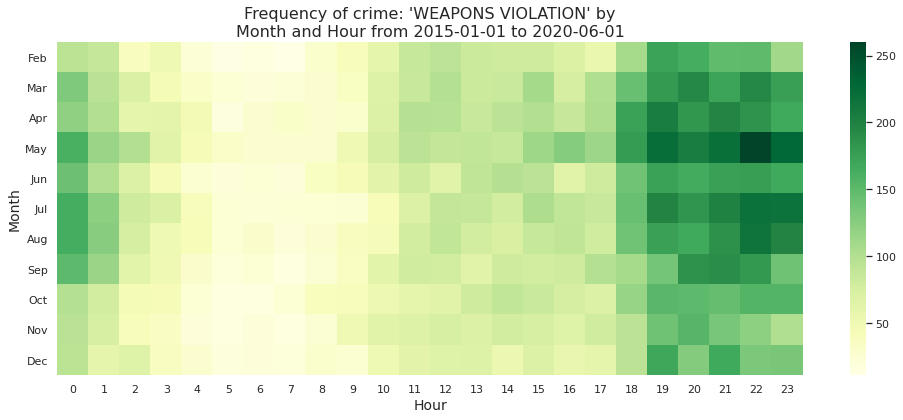

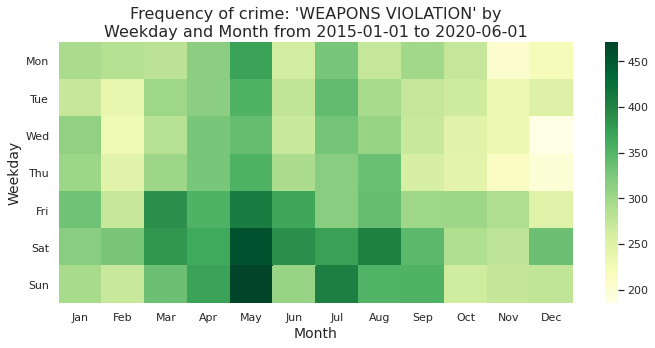

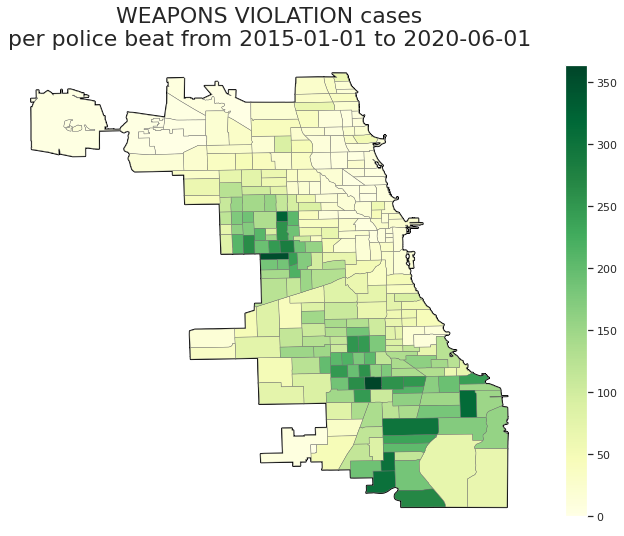

In [30]:
produce_visualizations(crime_descr='WEAPONS VIOLATION', crime_col='Primary Type', start_date=nb_start_date, 
                       end_date=nb_end_date, qmin=0)

## Weapons Violation: Unlawful Possession of a Handgun

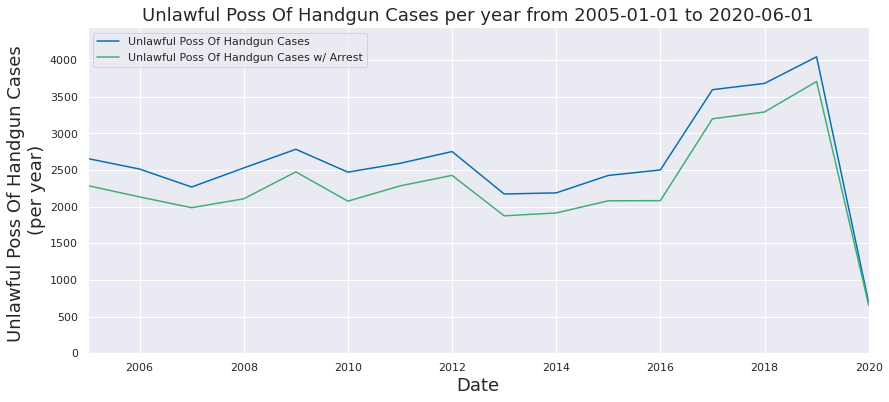

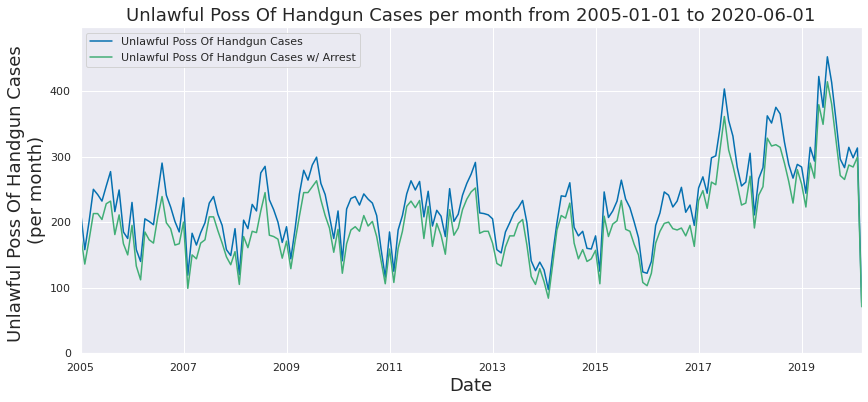

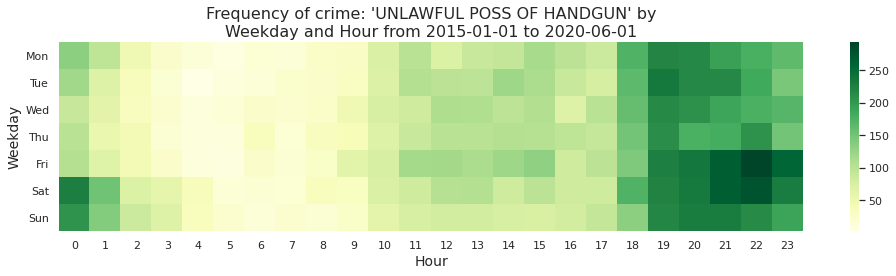

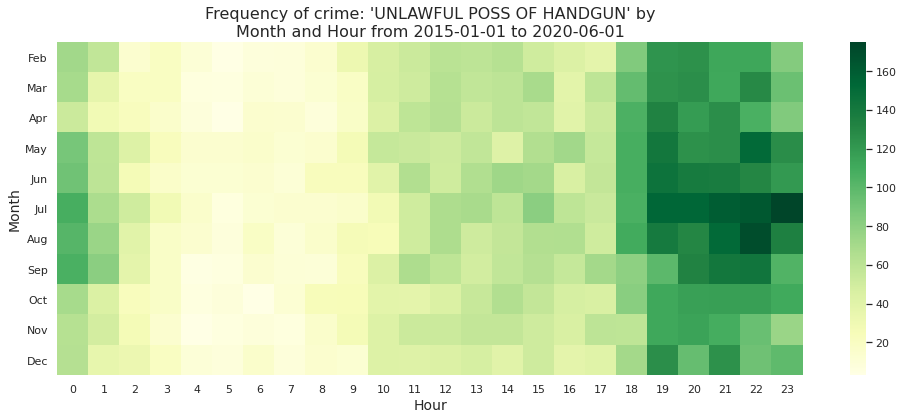

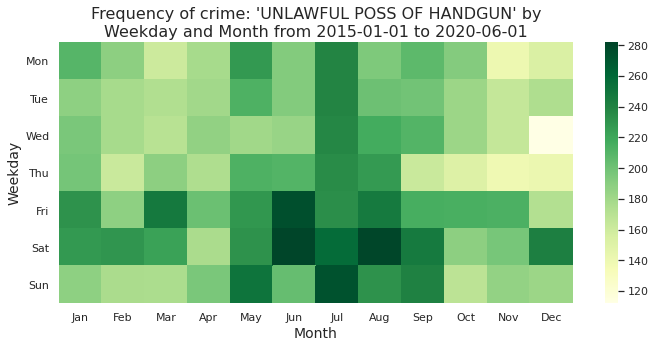

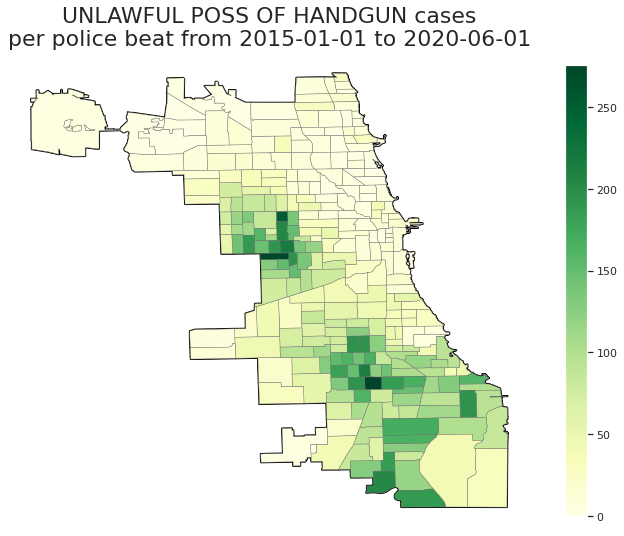

In [31]:
produce_visualizations(crime_descr='UNLAWFUL POSS OF HANDGUN', crime_col='Description', 
                       start_date=nb_start_date, end_date=nb_end_date)

## Weapons Violation: Unlawful use of a dangerous (non-handgun) weapon

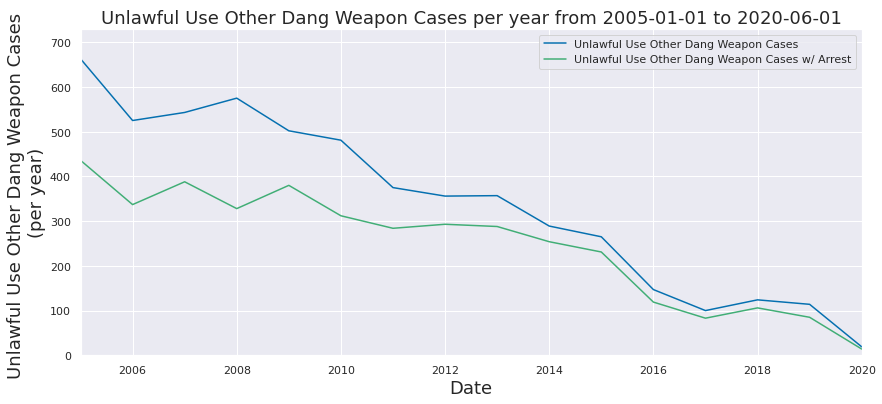

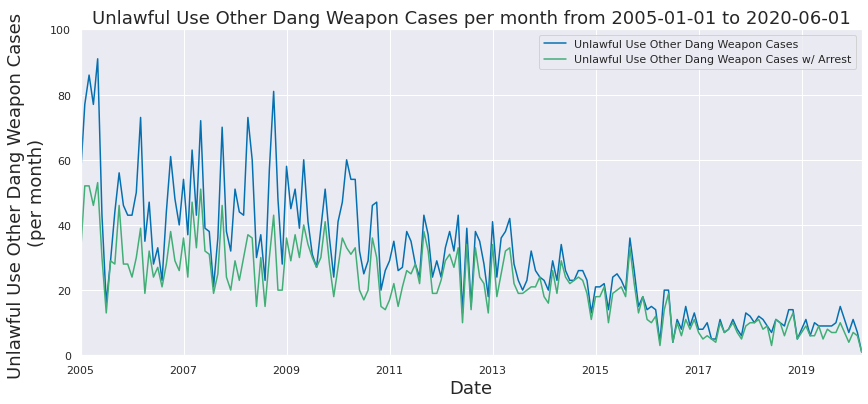

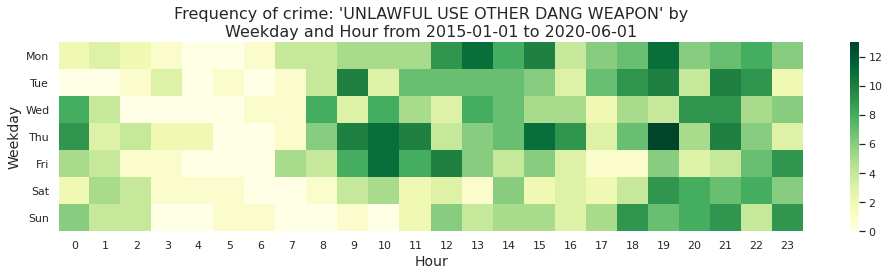

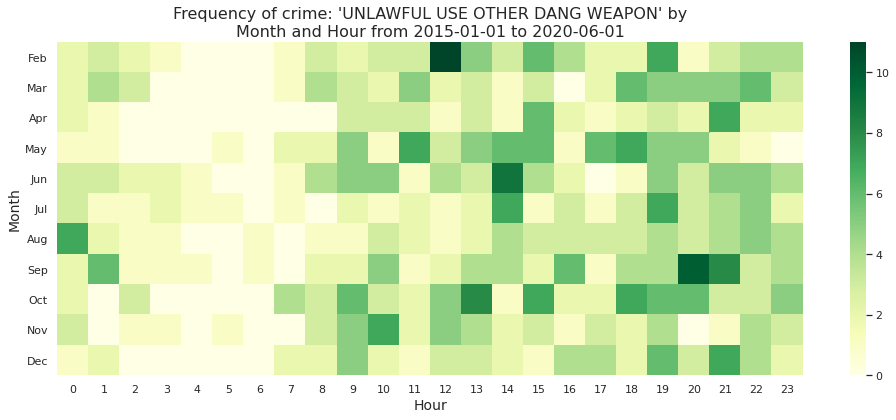

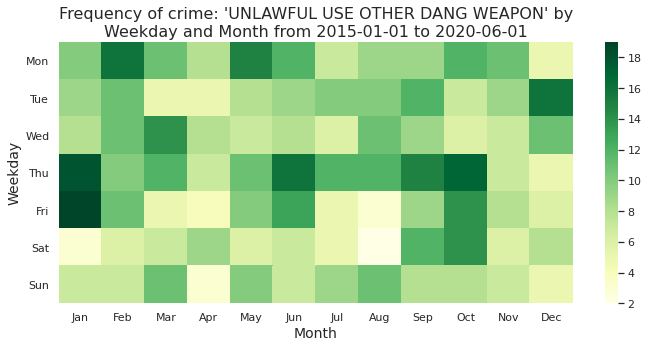

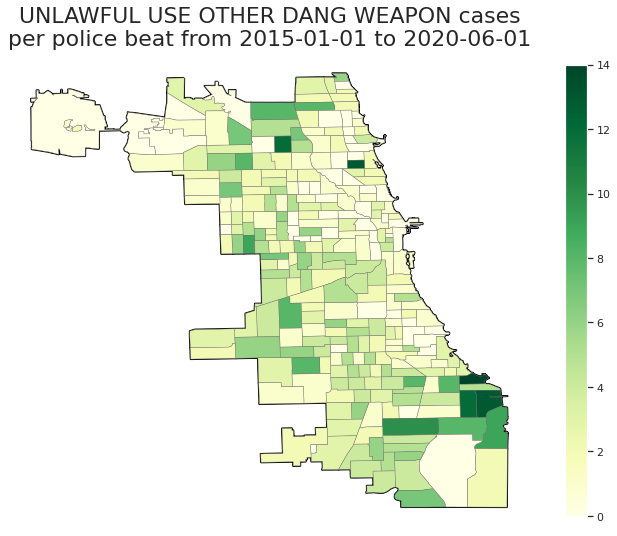

In [32]:
produce_visualizations(crime_descr='UNLAWFUL USE OTHER DANG WEAPON', crime_col='Description', 
                       start_date=nb_start_date, end_date=nb_end_date)

## Weapons Violation: Unlawful use of a handgun

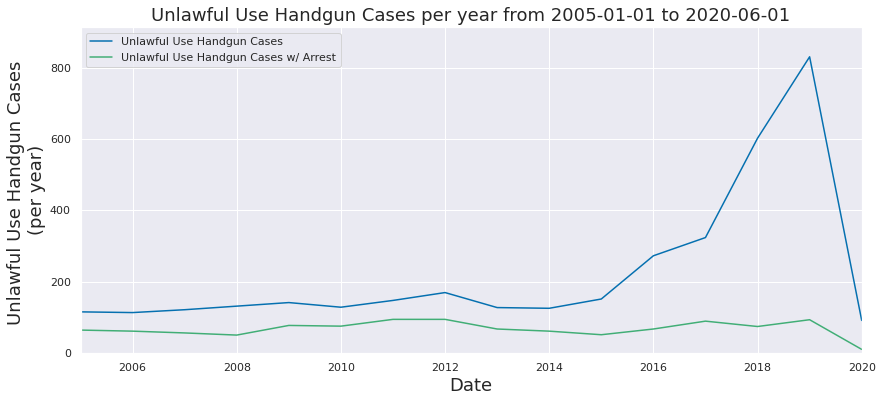

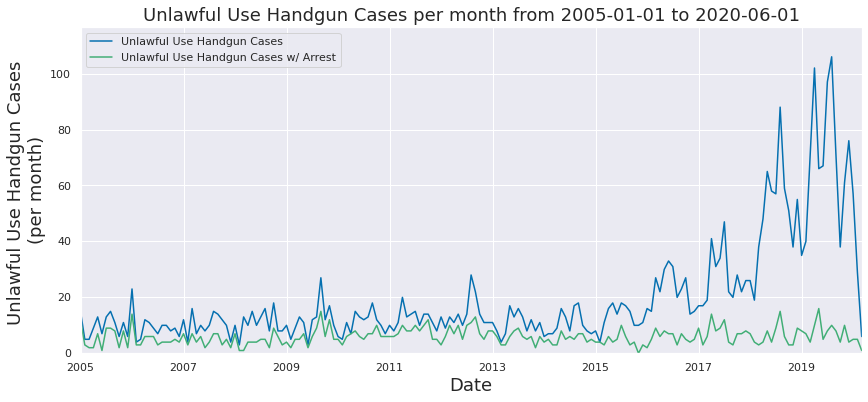

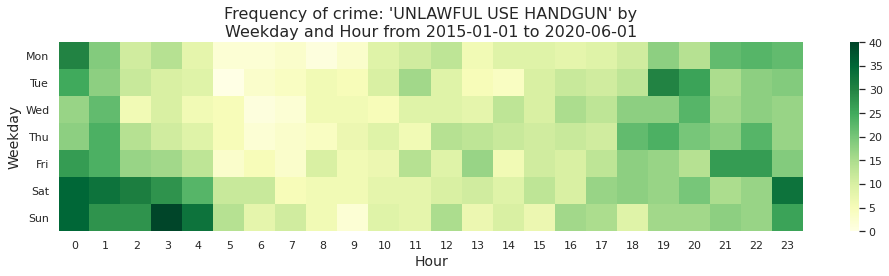

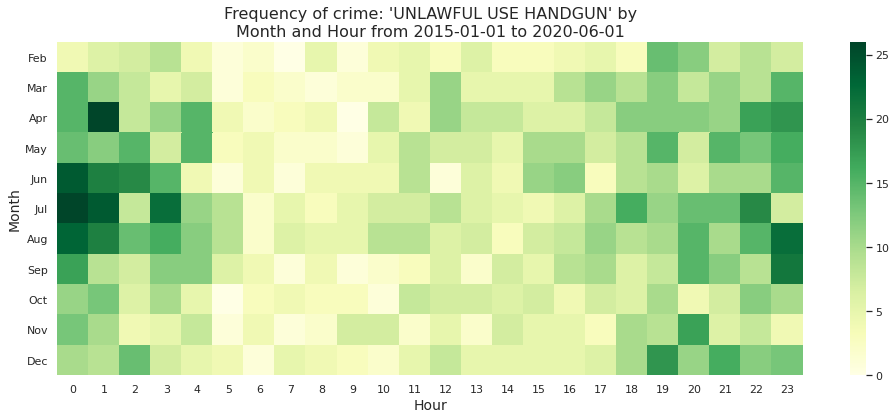

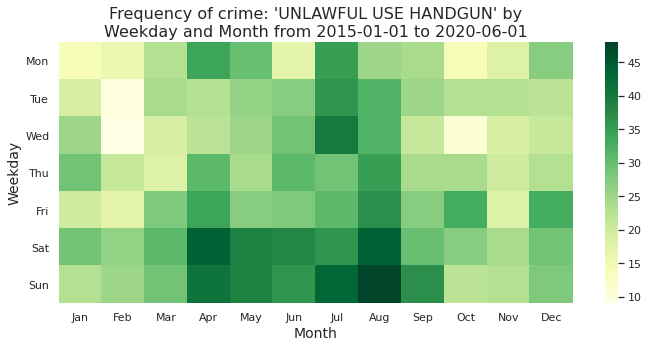

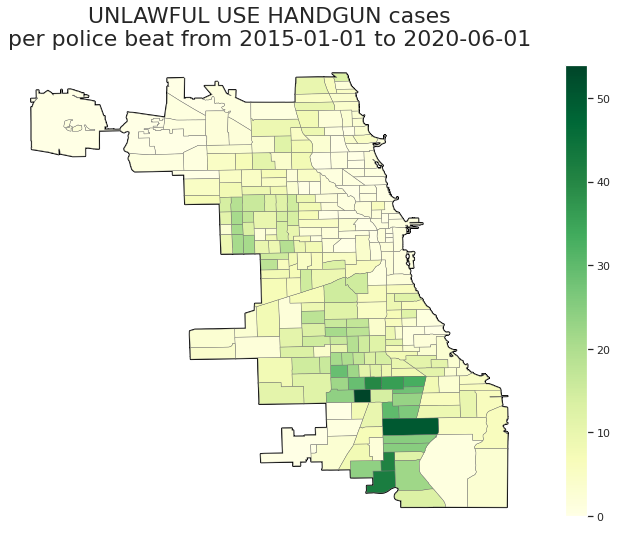

In [33]:
produce_visualizations(crime_descr='UNLAWFUL USE HANDGUN', crime_col='Description', start_date=nb_start_date, 
                       end_date=nb_end_date)

## ROBBERY: All

Number of ROBBERY Cases by description since 2001


ARMED: HANDGUN                    93805
STRONGARM - NO WEAPON             92075
AGGRAVATED                        13482
ARMED: OTHER DANGEROUS WEAPON     13016
ARMED:KNIFE/CUTTING INSTRUMENT    12283
ATTEMPT: STRONGARM-NO WEAPON      10242
AGGRAVATED VEHICULAR HIJACKING    10081
ATTEMPT: ARMED-HANDGUN             8554
VEHICULAR HIJACKING                5359
ATTEMPT: ARMED-KNIFE/CUT INSTR     2247
ATTEMPT: ARMED-OTHER DANG WEAP     2047
ARMED: OTHER FIREARM               1386
ATTEMPT: AGGRAVATED                 990
ARMED - HANDGUN                     787
STRONG ARM - NO WEAPON              599
Name: Description, dtype: int64

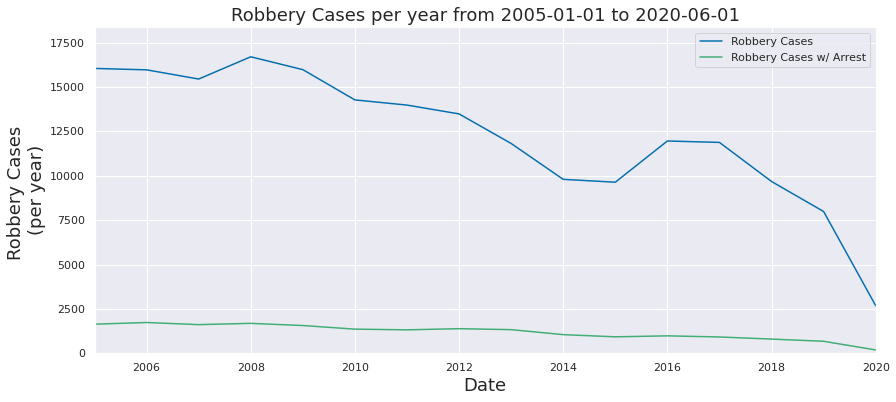

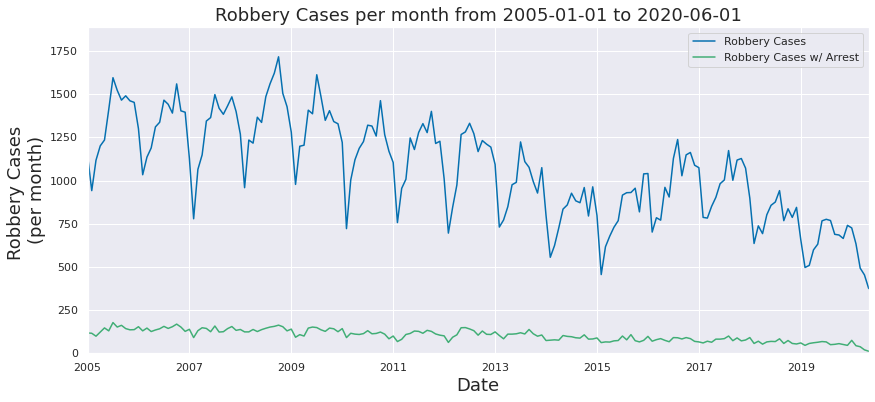

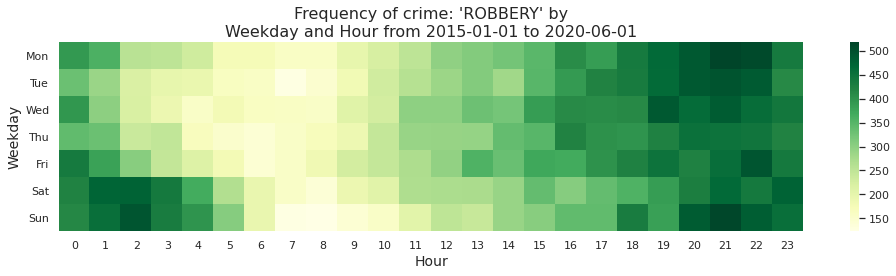

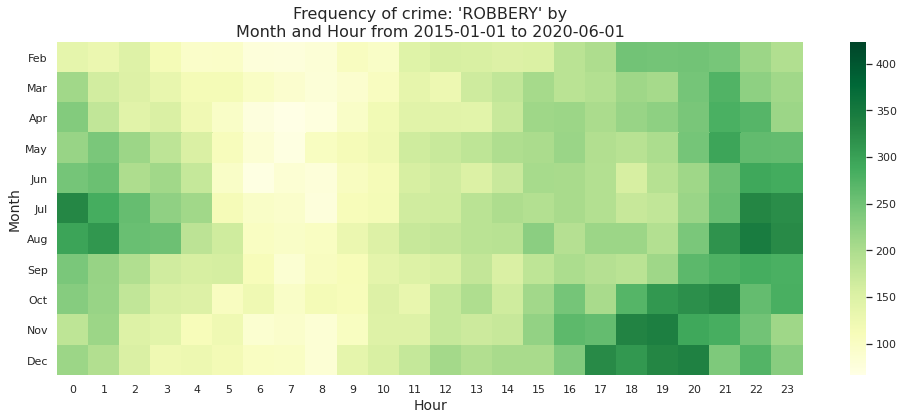

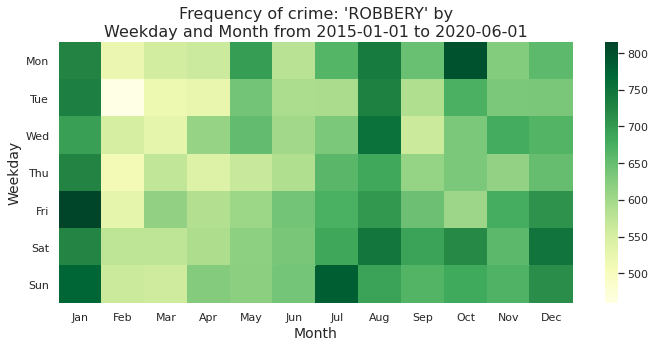

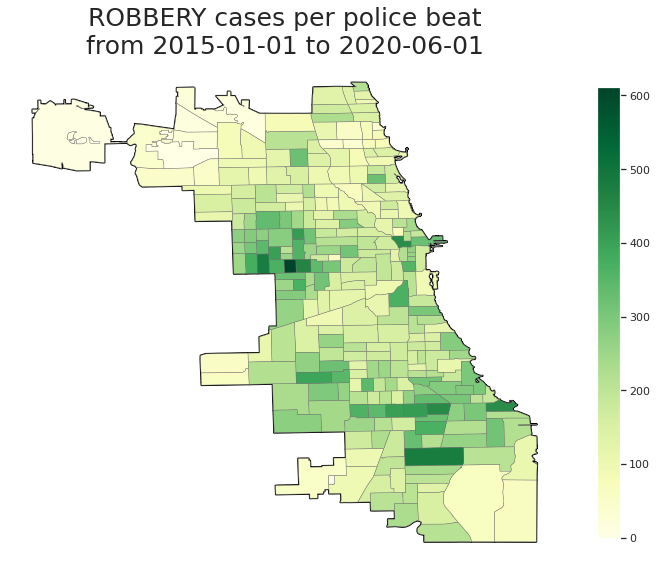

In [34]:
produce_visualizations(crime_descr='ROBBERY', crime_col='Primary Type', start_date=nb_start_date, end_date=nb_end_date, qmin=500)

## ROBBERY: Armed with a handgun

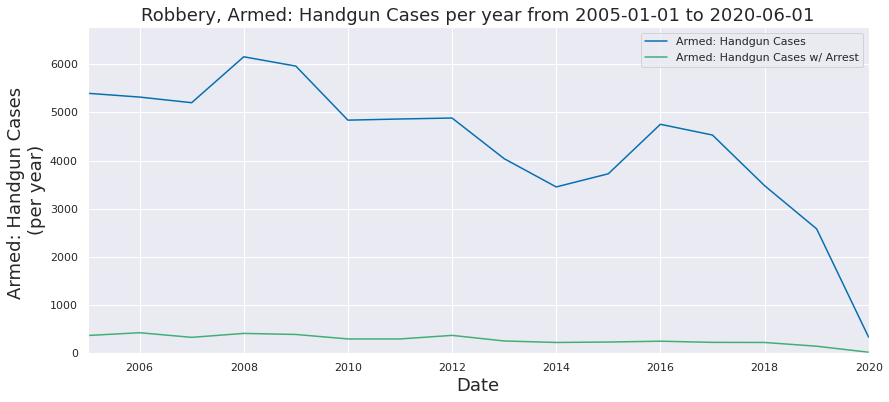

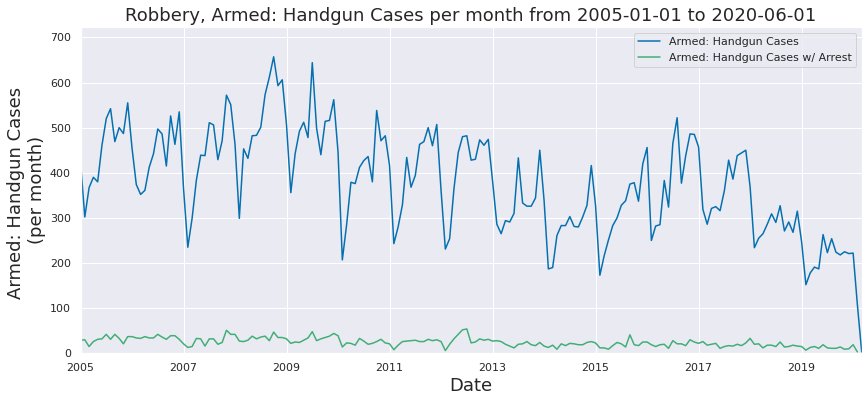

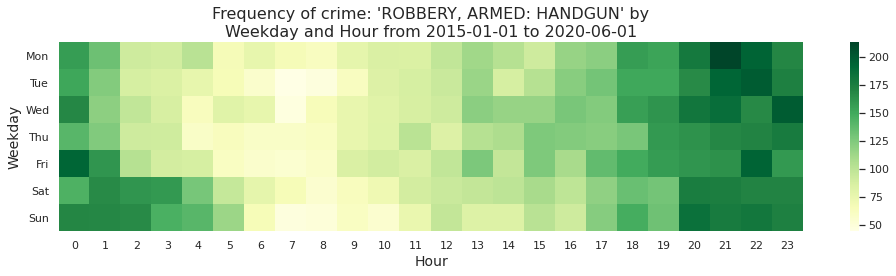

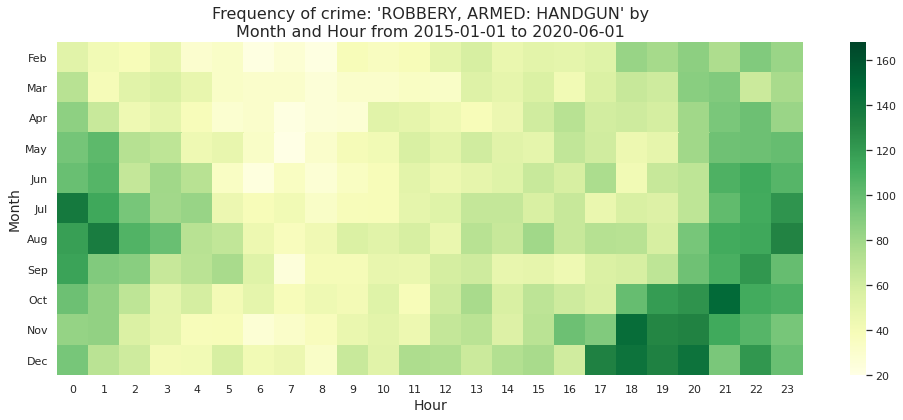

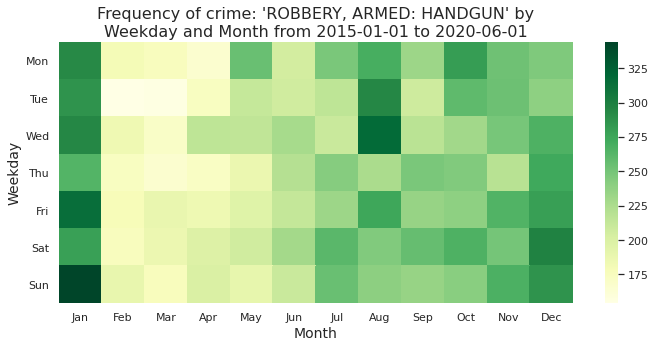

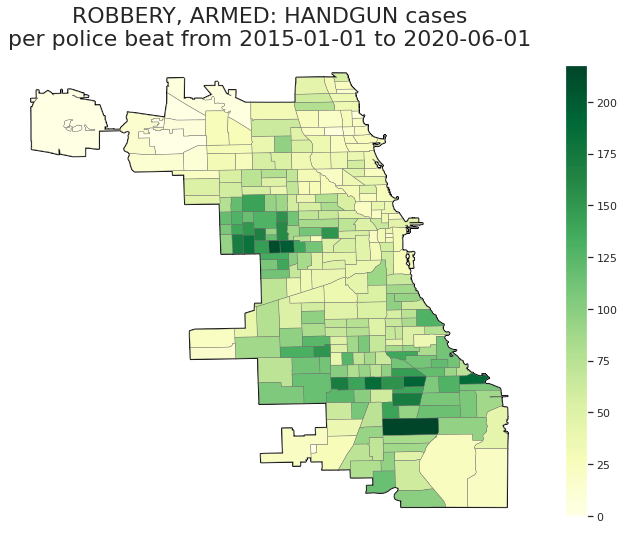

In [35]:
produce_visualizations(crime_descr='ARMED: HANDGUN', crime_col='Description', start_date=nb_start_date, 
                       end_date=nb_end_date, more_label='Robbery, ')

## ROBBERY: Strongarm

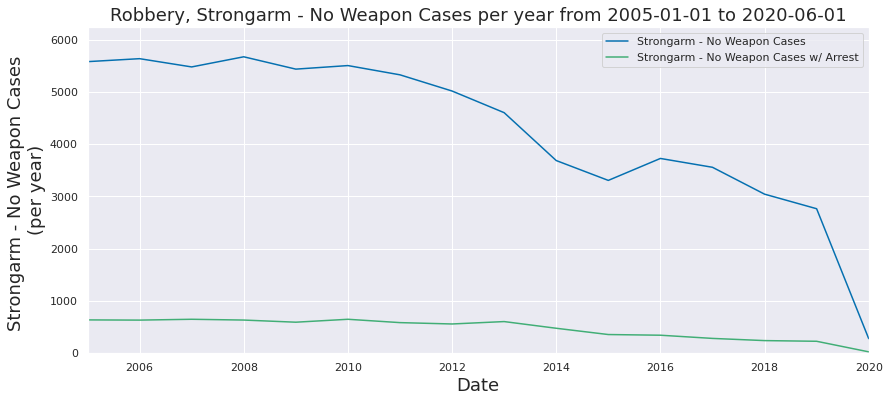

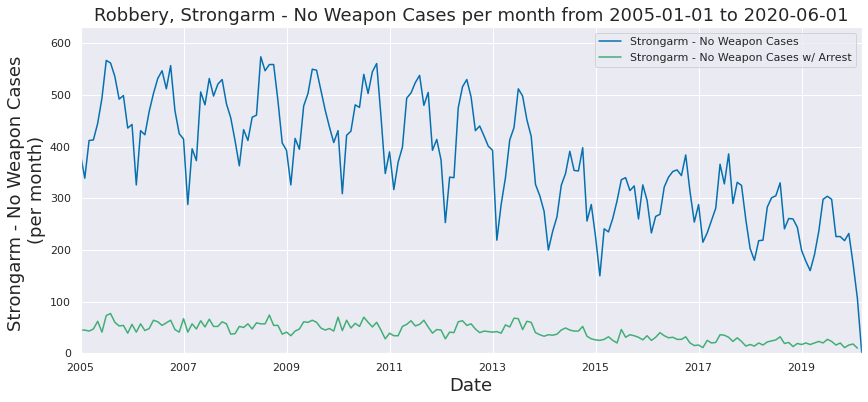

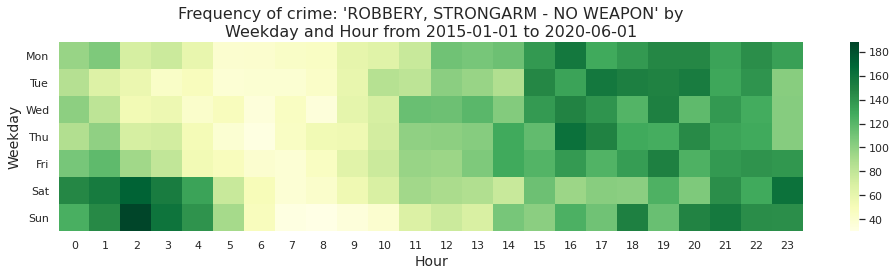

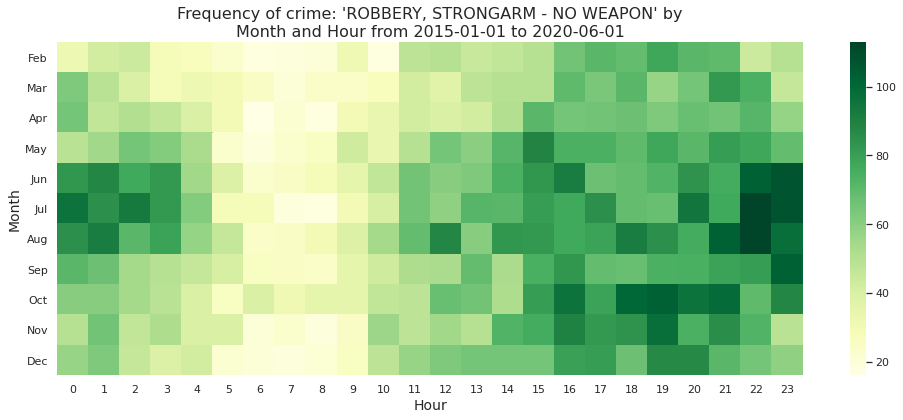

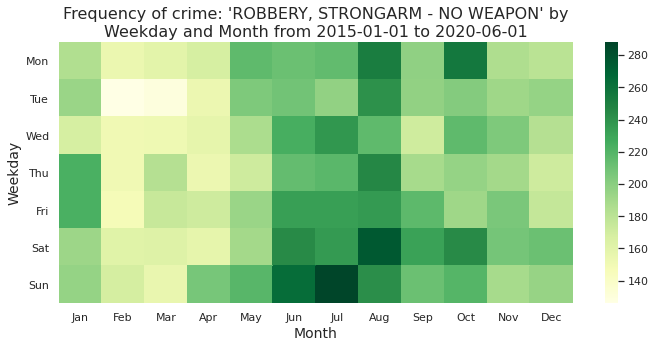

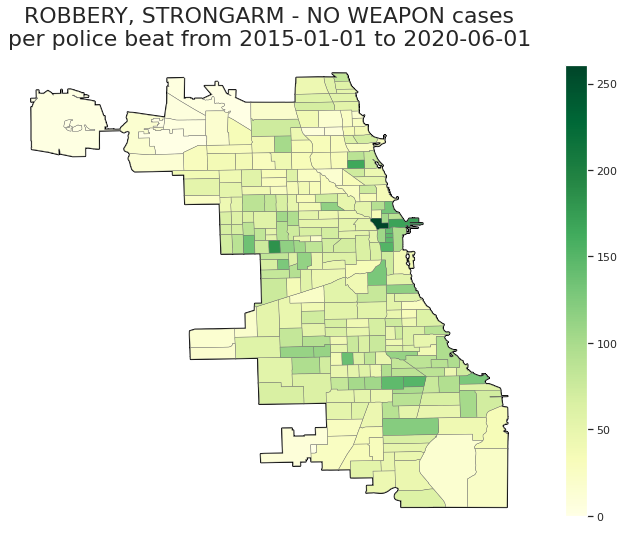

In [36]:
produce_visualizations(crime_descr='STRONGARM - NO WEAPON', crime_col='Description', start_date=nb_start_date, 
                       end_date=nb_end_date, more_label='Robbery, ')

## ROBBERY: Aggravated Vehicular Hijacking 

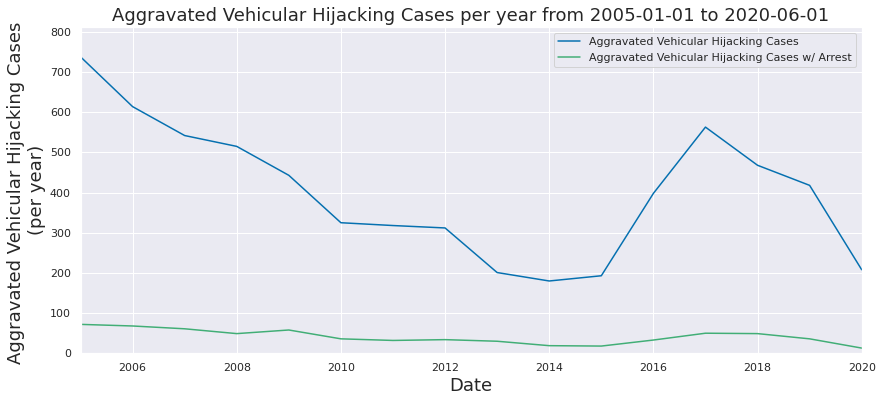

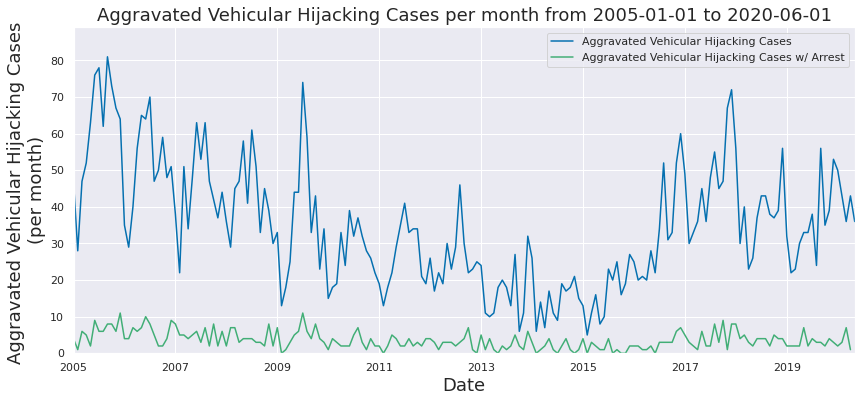

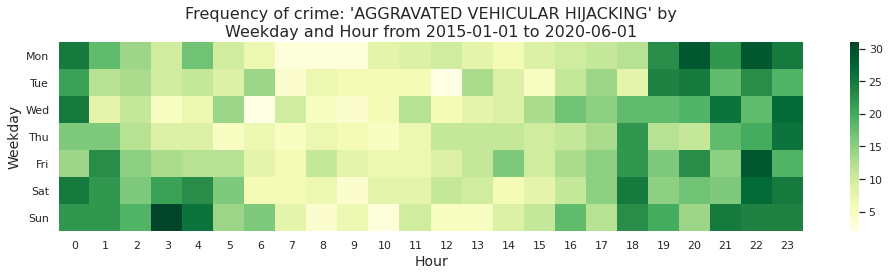

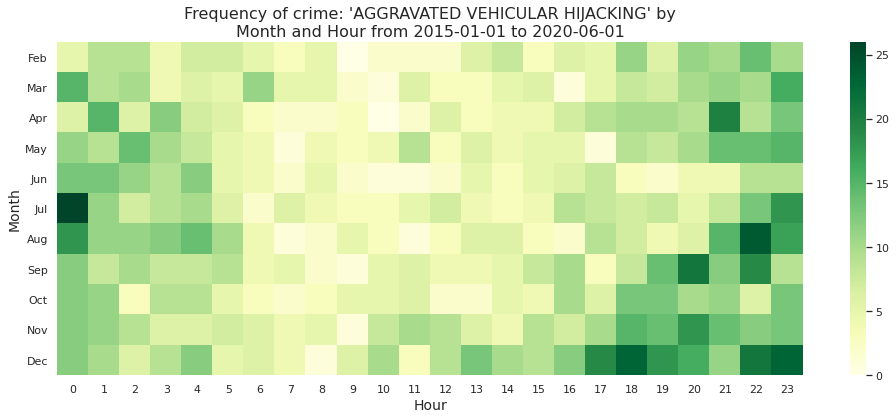

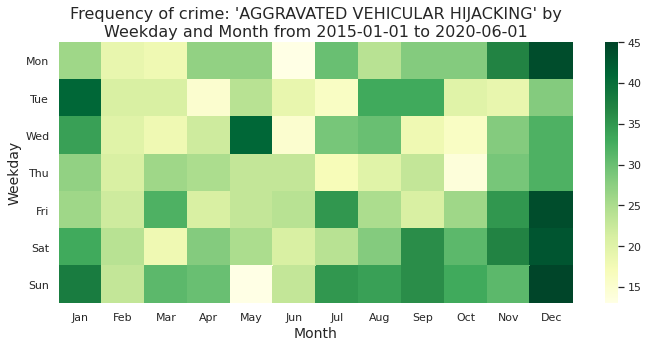

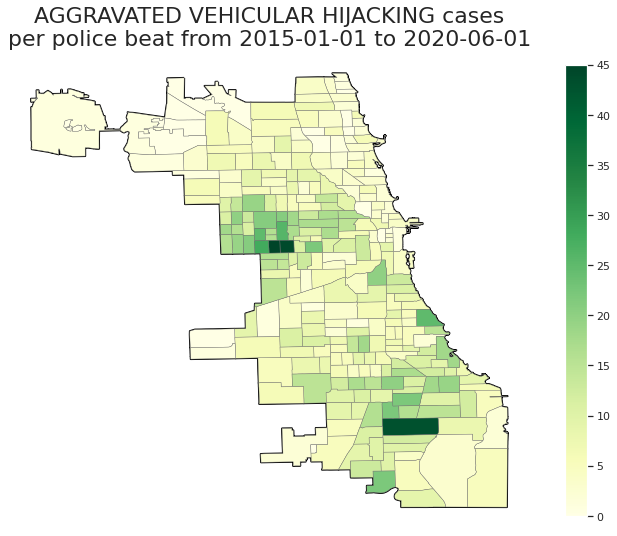

In [37]:
produce_visualizations(crime_descr='AGGRAVATED VEHICULAR HIJACKING', crime_col='Description', start_date=nb_start_date, 
                       end_date=nb_end_date)

## MOTOR VEHICLE THEFT: All

Motor vehicle theft is often a precursor to a shooting, as the vehicle is used in the shooting and then discarded.

Number of MOTOR VEHICLE THEFT Cases by description since 2001


AUTOMOBILE                         258134
TRUCK, BUS, MOTOR HOME              24770
THEFT/RECOVERY: AUTOMOBILE          23328
ATT: AUTOMOBILE                     11642
CYCLE, SCOOTER, BIKE W-VIN           5210
THEFT/RECOVERY: TRUCK,BUS,MHOME      2828
ATT: TRUCK, BUS, MOTOR HOME          1157
Name: Description, dtype: int64

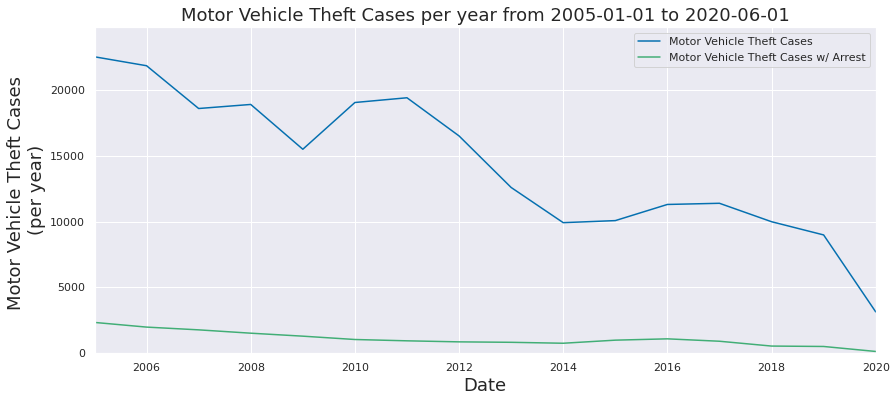

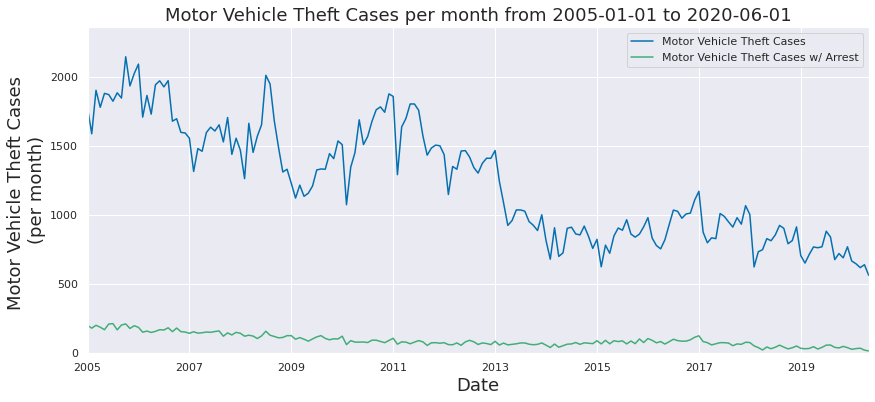

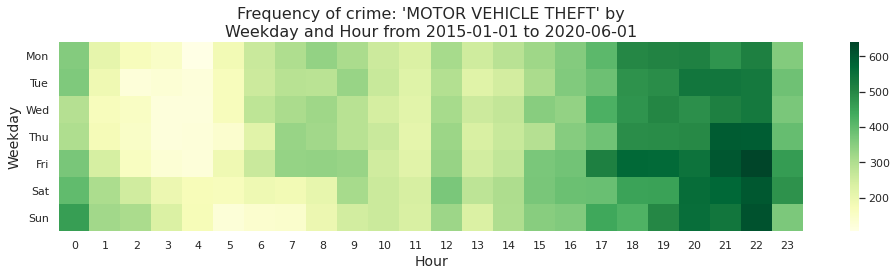

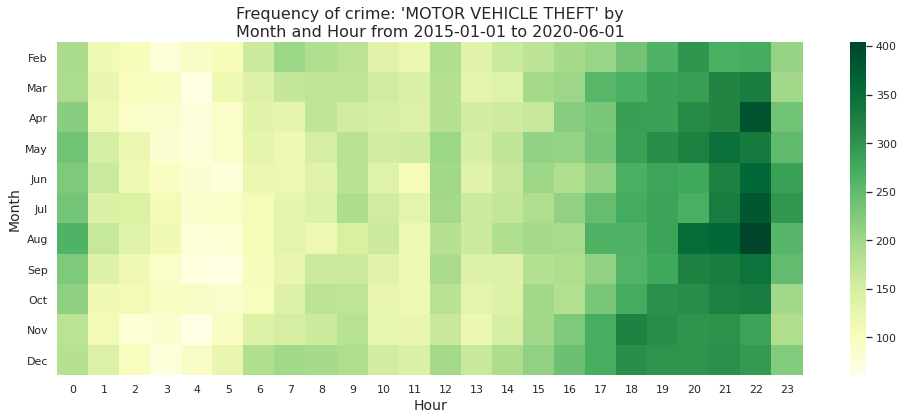

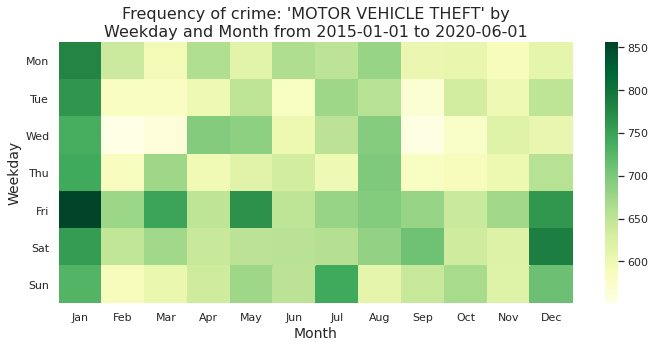

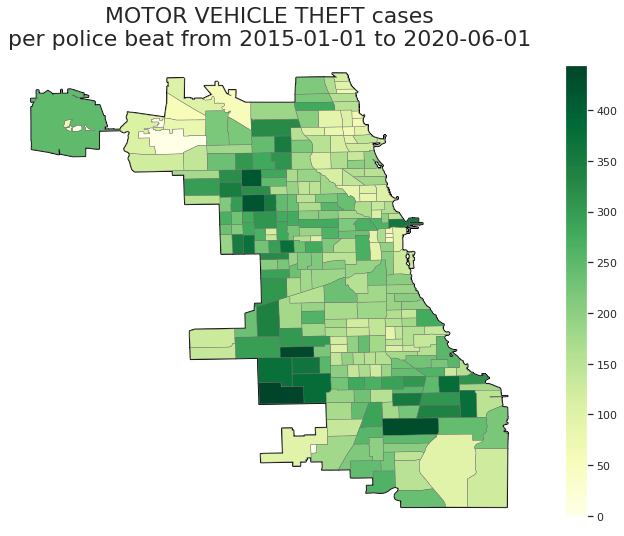

In [38]:
produce_visualizations(crime_descr='MOTOR VEHICLE THEFT', crime_col='Primary Type', start_date=nb_start_date, 
                       end_date=nb_end_date, qmin=500)

# Narcotics

Number of NARCOTICS Cases by description since 2001


POSS: CANNABIS 30GMS OR LESS      278174
POSS: CRACK                       121121
POSS: HEROIN(WHITE)                95788
SOLICIT NARCOTICS ON PUBLICWAY     27854
MANU/DELIVER: HEROIN (WHITE)       26446
POSS: COCAINE                      25471
MANU/DELIVER:CRACK                 24950
ATTEMPT POSSESSION NARCOTICS       21346
POSS: CANNABIS MORE THAN 30GMS     19092
FOUND SUSPECT NARCOTICS            17870
MANU/DEL:CANNABIS OVER 10 GMS      12501
MANU/DEL:CANNABIS 10GM OR LESS     11952
POSSESSION OF DRUG EQUIPMENT        9094
ATTEMPT POSSESSION CANNABIS         4619
POSS: HALLUCINOGENS                 4078
POSS: SYNTHETIC DRUGS               3938
FORFEIT PROPERTY                    3892
POSS: PCP                           3804
POSS: HEROIN(BRN/TAN)               3518
Name: Description, dtype: int64

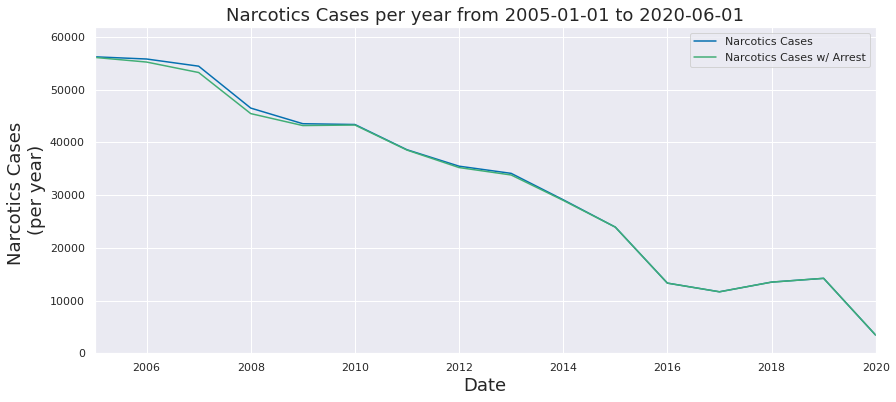

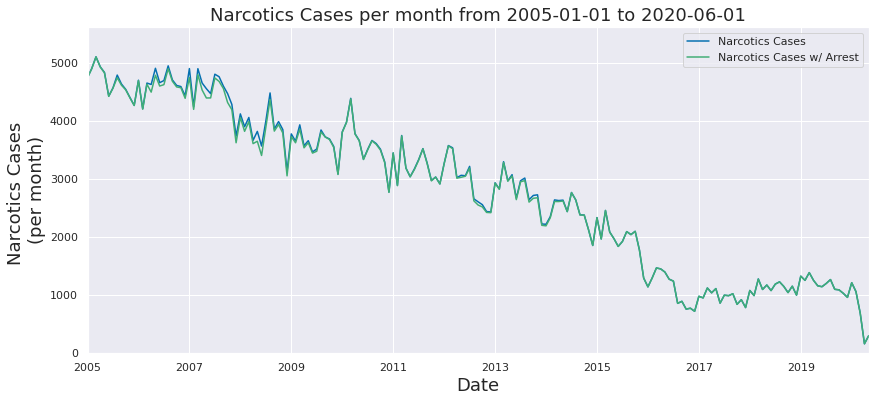

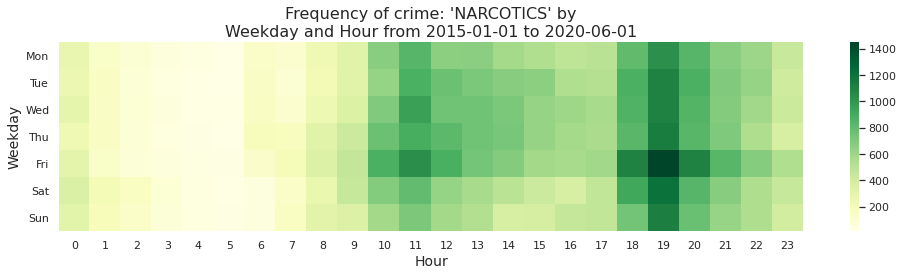

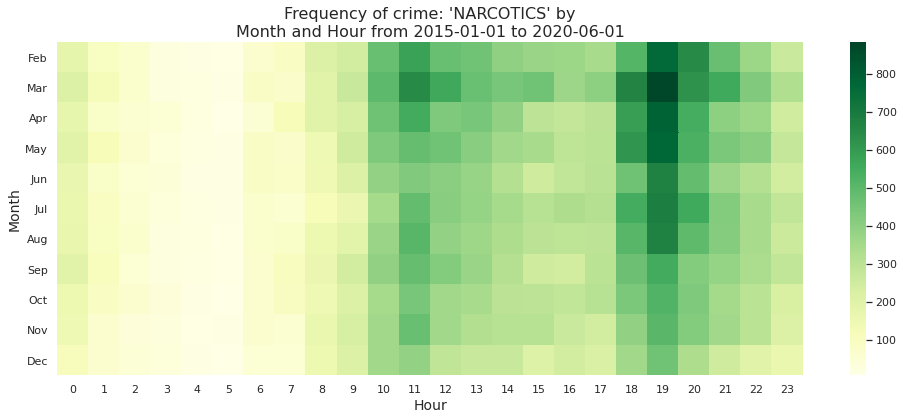

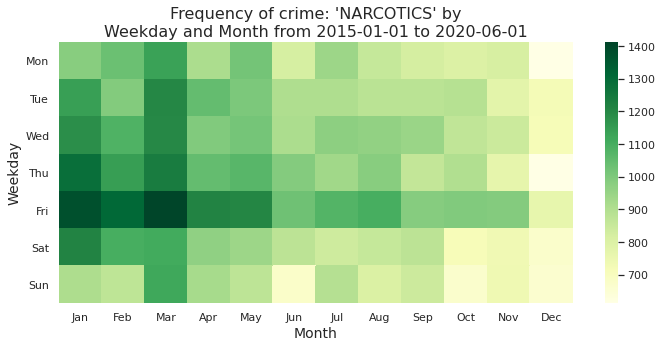

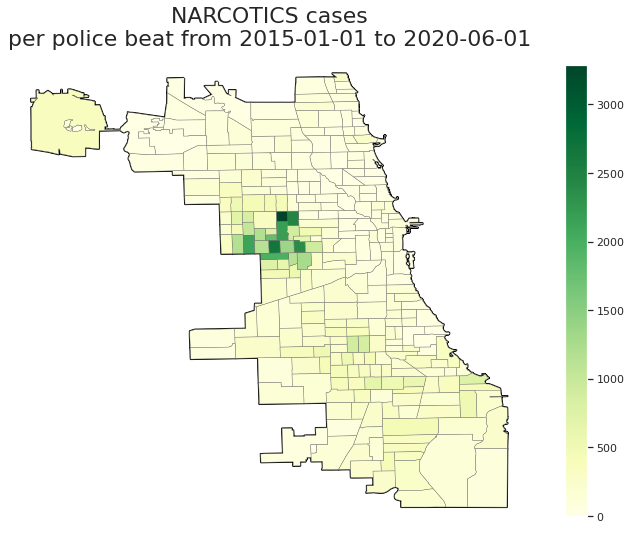

In [39]:
produce_visualizations(crime_descr='NARCOTICS', crime_col='Primary Type', start_date=nb_start_date, 
                       end_date=nb_end_date, qmin=3000)

### Narcotics: Cannabis Possession (under 30 grams)

In [ ]:
produce_visualizations(crime_descr='POSS: CANNABIS 30GMS OR LESS', crime_col='Description', 
                       start_date=nb_start_date, end_date=nb_end_date)

### Narcotics: Crack Possession

In [ ]:
produce_visualizations(crime_descr='POSS: CRACK', crime_col='Description', start_date=nb_start_date, 
                       end_date=nb_end_date)

### Narcotics: Heroin Possession

In [ ]:
produce_visualizations(crime_descr='POSS: HEROIN(WHITE)', crime_col='Description', start_date=nb_start_date, 
                       end_date=nb_end_date)

### Narcotics: Cocaine Possession

In [ ]:
produce_visualizations(crime_descr='POSS: COCAINE', crime_col='Description', start_date=nb_start_date, 
                       end_date=nb_end_date)

### Narcotics: Crack Possession

In [ ]:
produce_visualizations(crime_descr='POSS: SYNTHETIC DRUGS', crime_col='Description', start_date=nb_start_date, 
                       end_date=nb_end_date)

### Narcotics:  Soliciting narcotics in public

In [ ]:
produce_visualizations(crime_descr='SOLICIT NARCOTICS ON PUBLICWAY', crime_col='Description', 
                       start_date=nb_start_date, end_date=nb_end_date)

## THEFT: All

In [ ]:
produce_visualizations(crime_descr='THEFT', crime_col='Primary Type', start_date=nb_start_date, 
                       end_date=nb_end_date, qmin=500)

## THEFT: Petty (under \$500)

In [ ]:
produce_visualizations(crime_descr='$500 AND UNDER', crime_col='Description', start_date=nb_start_date, 
                       end_date=nb_end_date, more_label='Theft: ')

## THEFT: Pocket Picking

In [ ]:
produce_visualizations(crime_descr='POCKET-PICKING', crime_col='Description', start_date=nb_start_date, 
                       end_date=nb_end_date)

## THEFT: Purse snatching

In [ ]:
produce_visualizations(crime_descr='PURSE-SNATCHING', crime_col='Description', start_date=nb_start_date, 
                       end_date=nb_end_date)

## BURGLARY: All

In [ ]:
produce_visualizations(crime_descr='BURGLARY', crime_col='Primary Type', start_date=nb_start_date, 
                       end_date=nb_end_date, qmin=500)

## PROSTITUTION: All

In [ ]:
produce_visualizations(crime_descr='PROSTITUTION', crime_col='Primary Type', start_date=nb_start_date, 
                       end_date=nb_end_date, qmin=500)

## PROSTITUTION: Call operation

In [ ]:
produce_visualizations(crime_descr='CALL OPERATION', crime_col='Description', start_date=nb_start_date, 
                       end_date=nb_end_date, more_label='Prostitution: ')